# Import/Initialize

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from tqdm import tqdm

import time
from PIL import Image
import cv2
from skimage.color import rgba2rgb
from skimage.io import imread

import copy
from os import makedirs, path
from shutil import copyfile

from collections import OrderedDict

In [2]:
CHANNEL_N = 16
RADIUS = 1
NUM_FILTERS = 10
HIDDEN_N = 128
# HIDDEN_N = [128, CHANNEL_N]

EMBED_KERNEL = 5

TARGET_SIZE = 40
TARGET_PADDING = 16
BATCH_SIZE = 1

In [3]:
class Filter(nn.Module):
    def __init__(self, r=RADIUS, symmetric=True):
        super().__init__()
        
        
        f = torch.randn(2*r + 1)
        if symmetric:
            f = (f + f.flip(0))/2
        f = torch.ger(f, f)
#         f[r, r] = 0
        f = f - f.mean()
#         f = f - f.sum()/(f.numel() - 1)

        f[r, r] = 0
        f = f / (f.numel() - 1)
        
#         f = f / (f.numel())
        
        self.kernel = nn.Parameter(f)


class CAModel(nn.Module):
    def __init__(self, channel_n=CHANNEL_N, r=RADIUS, num_filters=NUM_FILTERS, hidden_n=HIDDEN_N):
        super().__init__()            
        
        self.channel_n = channel_n
        self.r = r
        self.num_filters = num_filters
        self.fire_rate = 0.5
        
        # define identity matrix
        identity = torch.zeros(2*self.r + 1)
        identity[self.r] = 1
        self.identity = torch.ger(identity, identity)
        self.identity = nn.Parameter(self.identity, requires_grad=False)

        # initialize perception kernel (trainable) 
        self.rand_filters = [Filter(self.r, symmetric=True).kernel for i in range(self.num_filters)]
        
        self.filters = nn.ParameterList([self.identity] + self.rand_filters)
        
        # Sobel filters
#         self.sx = torch.ger(torch.FloatTensor([1, 2, 1]), torch.FloatTensor([-1, 0, 1])) / 8
#         self.sx = nn.Parameter(self.sx, requires_grad=False)
#         self.sy = nn.Parameter(self.sx.T.type(torch.FloatTensor), requires_grad=False)
#         self.filters = [torch.cuda.FloatTensor(self.sx), torch.cuda.FloatTensor(self.sy)]
        
        
        # 1D conv network
        self.dmodel = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(self.channel_n*(self.num_filters + 1), hidden_n, 1, padding_mode='circular')),
            ('relu1', nn.LeakyReLU()),
            ('conv2', nn.Conv2d(hidden_n, self.channel_n, 1, padding_mode='circular')),
        ]))
        
        # 1D conv network
#         self.dmodel = [nn.Conv2d(self.channel_n*(self.num_filters + 1), hidden_n[0], 1, padding_mode='circular')]
#         self.dmodel.append(nn.LeakyReLU())
#         for i in range(1, len(hidden_n)):
#             l = nn.Conv2d(hidden_n[i-1], hidden_n[i], 1, padding_mode='circular')
#             self.dmodel.append(l)
#             if i < (len(hidden_n) - 1):
#                 self.dmodel.append(nn.LeakyReLU())
        
        gain=nn.init.calculate_gain('leaky_relu')
#         for l in self.dmodel:
#             if type(l) == nn.Conv2d:
#                 nn.init.xavier_uniform_(l.weight, gain)
#         self.dmodel = nn.Sequential(*self.dmodel)
        
        # update rule - initialized with zeros so initial behaviour is 'do nothing' (trainable)
#         gain=nn.init.calculate_gain('relu')
#         nn.init.zeros_(self.dmodel.conv2.weight)
#         nn.init.zeros_(self.dmodel.conv2.bias)

        nn.init.xavier_uniform_(self.dmodel.conv1.weight, gain)
#         nn.init.zeros_(self.dmodel.conv2.bias)

        nn.init.xavier_uniform_(self.dmodel.conv2.weight, gain)

         
    def perceive(self, x):              
#         filters = [self.identity] + [f.kernel for f in self.rand_filters]
#         filters = [self.identity, self.sx, self.sy]
        filters = [f for f in self.filters]
        numFilters = len(filters)
        k_size = 2*self.r + 1
        
        filters = torch.stack(filters).unsqueeze(0)
        filters = torch.repeat_interleave(filters, self.channel_n, dim=0)
        filters = filters.view(self.channel_n*numFilters, 1, k_size, k_size)  # combine filters into batch dimension (or out dimension, idk)
        
        # depthwise conv2d (groups==self.channel_n)
        x = F.pad(x, (self.r, self.r, self.r, self.r), mode='circular')
        y = F.conv2d(x, filters, padding=self.r, groups=self.channel_n) 
        y = y[:, :, self.r:-self.r, self.r:-self.r]
        return y
    
    def get_living_mask(self, x):
        alpha_channel = x[:, 3:4, :, :]
        alpha_channel = F.pad(alpha_channel, (self.r, self.r, self.r, self.r), mode='circular')

        alive_mask = F.max_pool2d(alpha_channel, kernel_size=2*self.r+1, stride=1, padding=self.r) > 0.1
        alive_mask = alive_mask[:, :, self.r:-self.r, self.r:-self.r] 
        
        death_mask = F.avg_pool2d(alpha_channel, kernel_size=2*self.r+1, stride=1, padding=self.r) < 0.2
        death_mask = death_mask[:, :, self.r:-self.r, self.r:-self.r] 
        return alive_mask.cuda() & death_mask.cuda()
    
    def forward(self, x, fire_rate=None, step_size=1.0):
        
        pre_life_mask = self.get_living_mask(x)
        
        y = self.perceive(x)
        dx = self.dmodel(y) * step_size 
        
        if fire_rate is None:
            fire_rate = self.fire_rate
        update_mask = (torch.rand(x[:, :1, :, :].shape) <= fire_rate).type(torch.FloatTensor).cuda()
        x = x + dx * update_mask
        
        post_life_mask = self.get_living_mask(x)
        life_mask = (pre_life_mask & post_life_mask).type(torch.FloatTensor).cuda()
        
        x = x * life_mask
 
        return x

def to_rgba(x):
    return x[:, :4, :, :]

def to_alpha(x):
    return np.clip(x[:, 3:4, :, :], 0.0, 1.0)

def to_rgb(x):
    # assume rgb premultiplied by alpha
    rgb, a = x[:, :3, :, :], to_alpha(x)
    return 1.0-a+rgb

def load_image(fname, max_size=TARGET_SIZE):
    img = Image.open(fname)
    img.thumbnail((max_size, max_size), Image.ANTIALIAS)
    img = np.float32(img)/255.0
    # premultiply RGB by Alpha
    img[..., :3] *= img[..., 3:]
    return img

def copy_notebook(folder):
    src = 'CA_pop_totrain_embedder.ipynb'
    dst = path.join(folder, src)
    copyfile(src, dst)

In [4]:
class Embedder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.c1 = nn.Conv2d(4, 32, EMBED_KERNEL, padding=EMBED_KERNEL-1, padding_mode='circular', stride=EMBED_KERNEL//2)
        self.c2 = nn.Conv2d(32, 32, EMBED_KERNEL, padding=EMBED_KERNEL-1, padding_mode='circular', stride=EMBED_KERNEL//2)
        mp_kernel = 5  # SIZE / (mp_kernel*2) / mp_kernal = 1
        self.mp1 = nn.MaxPool2d(3, stride=2)
        
        self.c3 = nn.Conv2d(32, 32, EMBED_KERNEL, padding=EMBED_KERNEL-1, padding_mode='circular', stride=EMBED_KERNEL//2)
        self.c4 = nn.Conv2d(32, 8, EMBED_KERNEL, padding=EMBED_KERNEL-1, padding_mode='circular')
        self.mp2 = nn.AvgPool2d(3, stride=2)
        
        # average pooling
        
    def forward(self, x):
        z = F.leaky_relu(self.c1(x))
        z = F.leaky_relu(self.c2(z))
        z = self.mp1(z)
        
        z = F.leaky_relu(self.c3(z))
        z = self.c4(z)
        z = self.mp2(z)
        
        return z

# Run for fun (remove zero weight initialization on final layer)

In [ ]:
CA_run = CAModel()

if torch.cuda.is_available():
    CA_run.cuda()

In [ ]:
SIZE = 257

x = torch.cuda.FloatTensor(np.random.standard_normal(size=(CHANNEL_N, SIZE, SIZE))).unsqueeze(0) > 3
x = x.type(torch.cuda.FloatTensor)
# x = torch.cuda.FloatTensor(np.zeros((CHANNEL_N, SIZE, SIZE))).unsqueeze(0)
# x[:, 3:, SIZE//2, SIZE//2] = 1
# x[:, 3:, 256//3 : 2*256//3, 256//3 : 2*256//3] = 1

# x[:, 3:, SIZE//3, SIZE//3] = 1
# x[:, 3:, 2*SIZE//3, 2*SIZE//3] = 1

imgs = []

timeSteps = 500
for i in range(timeSteps):
#     print(i, stop)
    nx = x.cpu().numpy()[0, 0:4, :, :].transpose(1, 2, 0)
    nx = rgba2rgb(nx)
    imgs.append(nx)
    
    if i%50 == 0:
        plt.clf()
        plt.imshow(nx)
        plt.gcf().set_size_inches((8,8))
        clear_output(wait=True)
        print(f'{i}')
        display(plt.gcf())
        time.sleep(0.01)

    x = torch.tanh(CA_run.forward(x, step_size=1, fire_rate=1))
    x = x.detach()
    

fname = time.strftime("%Y%m%d-%H%M%S")
out = cv2.VideoWriter(f'CA-{fname}.avi',cv2.VideoWriter_fourcc(*'DIVX'), 60, (SIZE, SIZE), 3)

for img in imgs:
    img = np.uint8(cv2.cvtColor(img, cv2.COLOR_RGB2BGR)*255.0)
    out.write(img)
out.release()

In [ ]:
fname = time.strftime("%Y%m%d-%H%M%S")
out = cv2.VideoWriter(f'CA-{fname}.avi',cv2.VideoWriter_fourcc(*'DIVX'), 150, (SIZE, SIZE), 3)

for img in imgs:
    img = np.uint8(cv2.cvtColor(img, cv2.COLOR_RGB2BGR)*255.0)
    out.write(img)
out.release()

# Load Checkpoint

In [5]:
EPOCH = 5 
PATH = path.join('models', 'model_20200428-013218', 'epoch_' + str(EPOCH).zfill(4) + '.tar')
checkpoint = torch.load(PATH)

In [20]:
NUM_POP = len(checkpoint['model_state_dict'])

# load models
CAs = [CAModel().cuda() for i in range(NUM_POP)]
[CA.load_state_dict(checkpoint['model_state_dict'][i]) for i, CA in enumerate(CAs)]
embed = Embedder().cuda()
embed.load_state_dict(checkpoint['embedder_state_dict'])

# load optimizers
Optims_CAs = [torch.optim.Adam([p for p in CA.parameters()], lr=1e-3) for CA in CAs]
[optim.load_state_dict(checkpoint['optimizer_state_dict'][i]) for i, optim in enumerate(Optims_CAs)]
optim_emb = torch.optim.Adam([p for p in embed.parameters()], lr=1e-3)
optim_emb.load_state_dict(checkpoint['embedder_optimizer_state_dict'])

tloss = nn.TripletMarginLoss()

# Train

In [5]:
seed = 10000
np.random.seed(seed)
torch.manual_seed(seed)

NUM_POP = 300

CA_orig = CAModel()

CAs = [CA_orig]
for i in range(NUM_POP - 1):
    CAs.append(copy.deepcopy(CA_orig))

CA = CAModel()
embed = Embedder().cuda()
if torch.cuda.is_available():
    for CA in CAs:
        CA.cuda()
        
    embed.cuda()
    
tloss = nn.TripletMarginLoss()

In [6]:
optim_emb = torch.optim.Adam([p for p in embed.parameters()], lr=1e-3)
Optims_CAs = [torch.optim.Adam([p for p in CA.parameters()], lr=1e-3) for CA in CAs]




  0%|          | 0/300 [00:00<?, ?it/s]

0 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


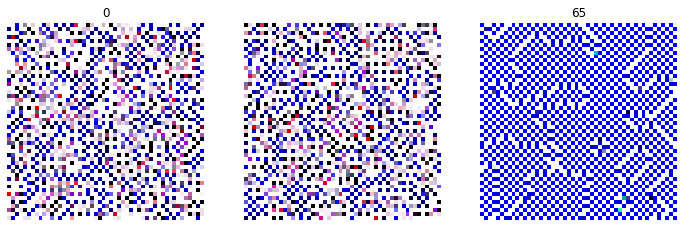




  0%|          | 1/300 [00:00<02:59,  1.67it/s]

1 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


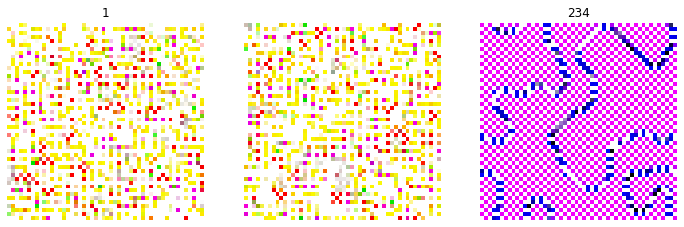




  1%|          | 2/300 [00:01<03:02,  1.63it/s]

2 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


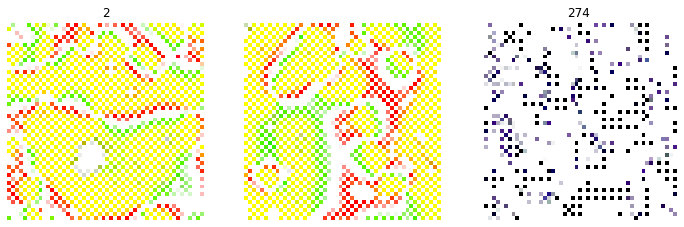




  1%|          | 3/300 [00:01<02:58,  1.66it/s]

3 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


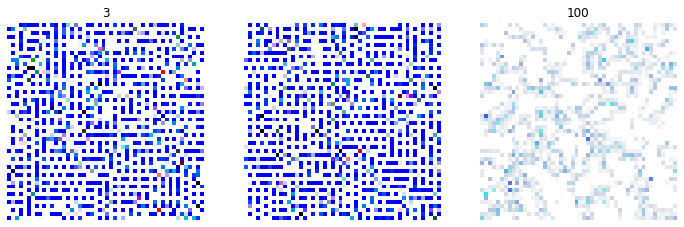




  1%|▏         | 4/300 [00:02<02:55,  1.69it/s]

4 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


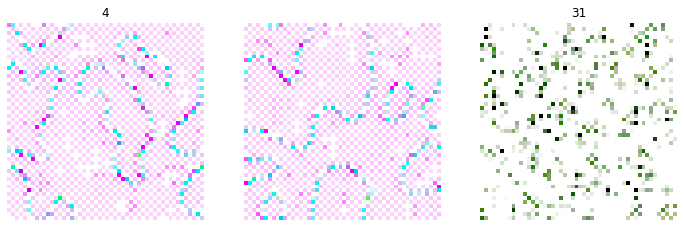




  2%|▏         | 5/300 [00:02<02:53,  1.70it/s]

5 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


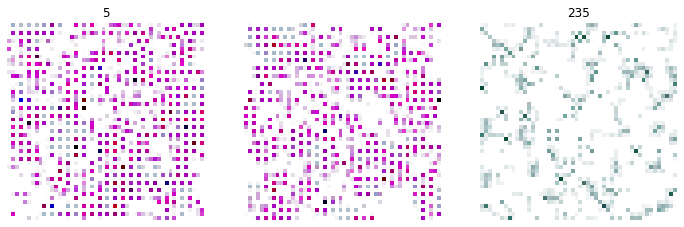




  2%|▏         | 6/300 [00:03<02:51,  1.71it/s]

6 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


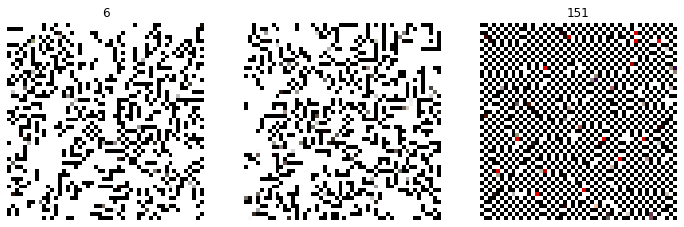




  2%|▏         | 7/300 [00:04<02:49,  1.72it/s]

7 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


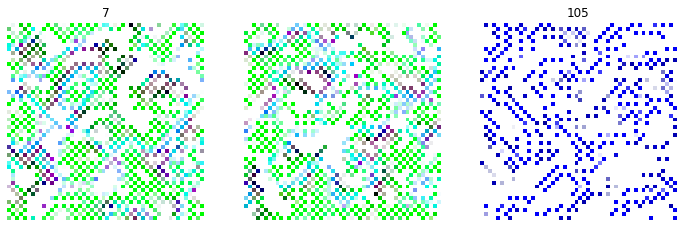




  3%|▎         | 8/300 [00:04<02:49,  1.73it/s]

8 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


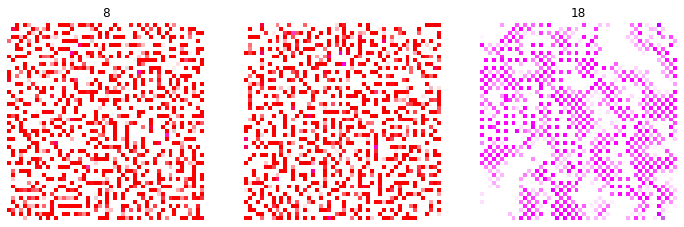




  3%|▎         | 9/300 [00:05<02:47,  1.73it/s]

9 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


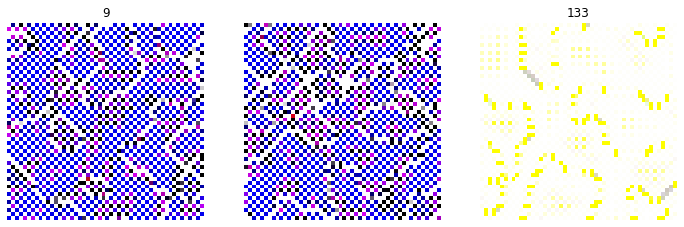




  3%|▎         | 10/300 [00:05<02:47,  1.73it/s]

10 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


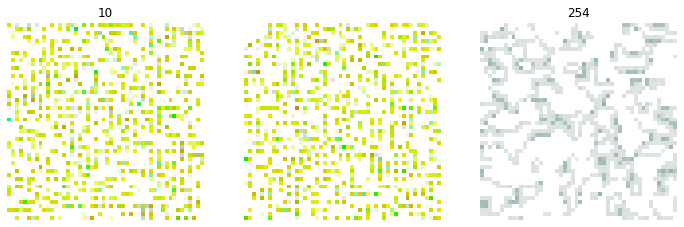




  4%|▎         | 11/300 [00:06<02:46,  1.74it/s]

11 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


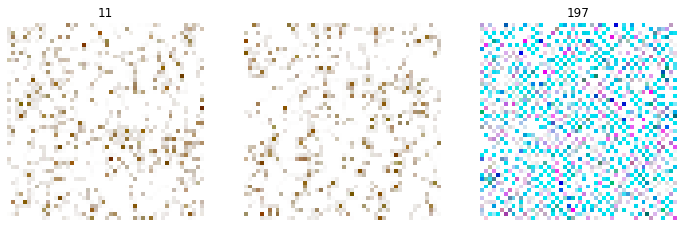




  4%|▍         | 12/300 [00:06<02:45,  1.74it/s]

12 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


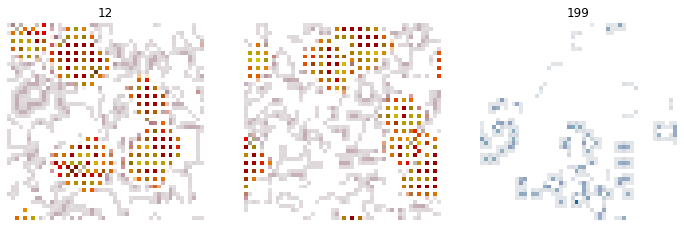




  4%|▍         | 13/300 [00:07<02:44,  1.74it/s]

13 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


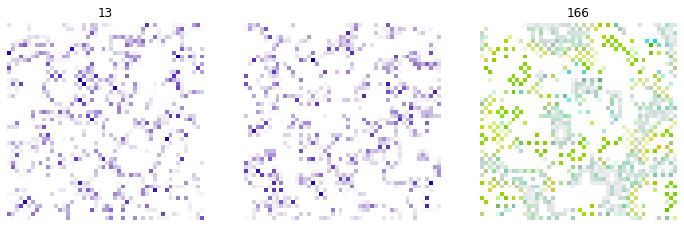




  5%|▍         | 14/300 [00:08<02:44,  1.74it/s]

14 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


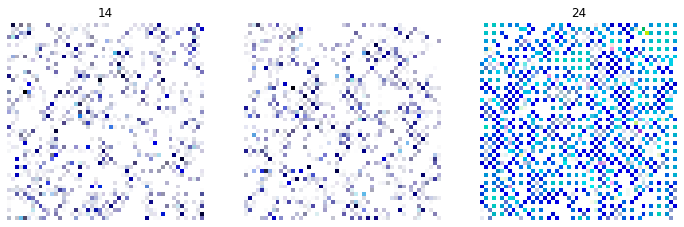




  5%|▌         | 15/300 [00:08<02:43,  1.74it/s]

15 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


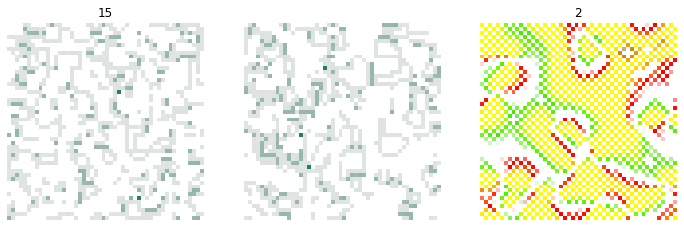




  5%|▌         | 16/300 [00:09<02:50,  1.66it/s]

16 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


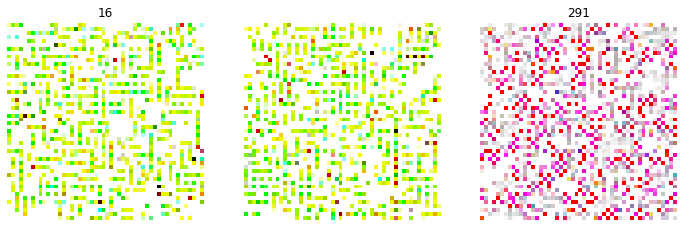




  6%|▌         | 17/300 [00:09<02:47,  1.68it/s]

17 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


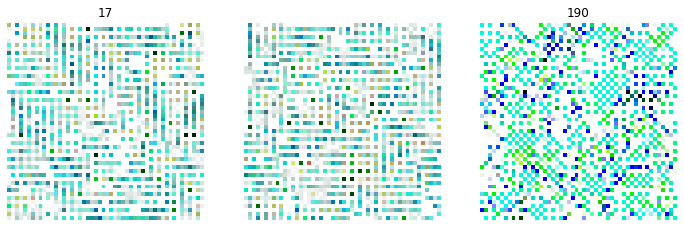




  6%|▌         | 18/300 [00:10<02:46,  1.70it/s]

18 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


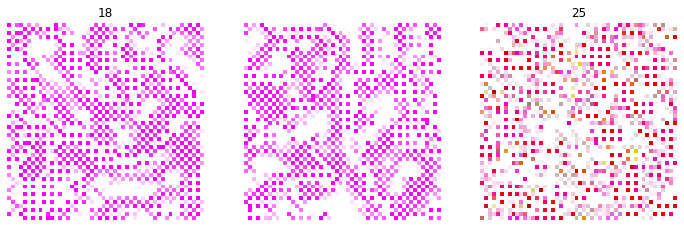




  6%|▋         | 19/300 [00:11<02:44,  1.71it/s]

19 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


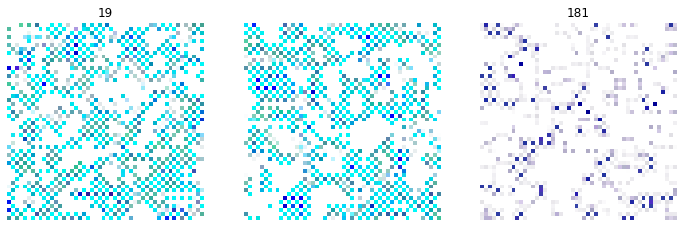




  7%|▋         | 20/300 [00:11<02:42,  1.72it/s]

20 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


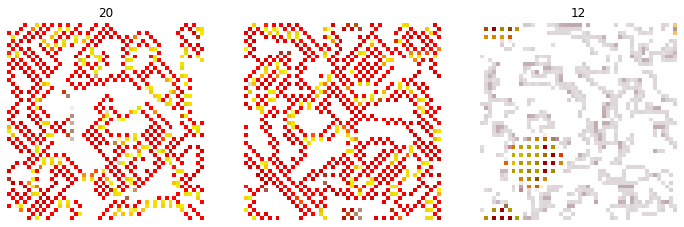




  7%|▋         | 21/300 [00:12<02:41,  1.73it/s]

21 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


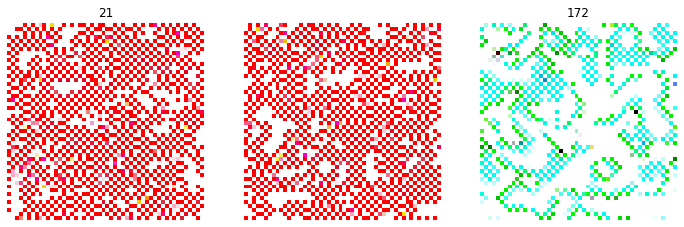




  7%|▋         | 22/300 [00:12<02:40,  1.73it/s]

22 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


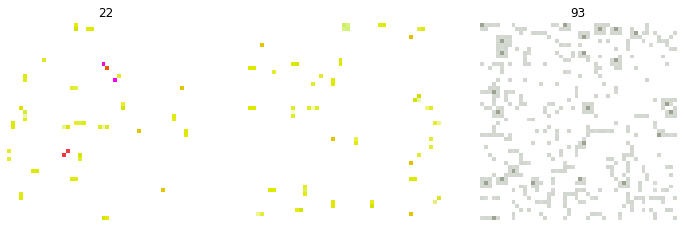




  8%|▊         | 23/300 [00:13<02:39,  1.74it/s]

23 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


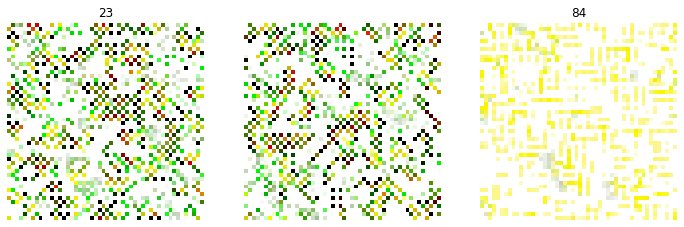




  8%|▊         | 24/300 [00:13<02:38,  1.74it/s]

24 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


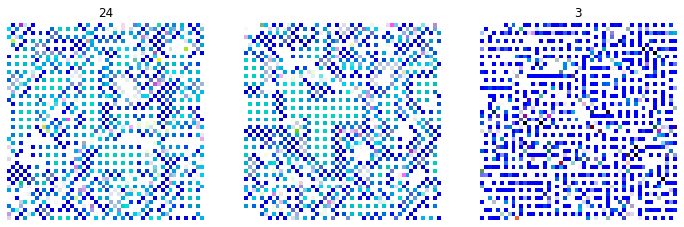




  8%|▊         | 25/300 [00:14<02:38,  1.74it/s]

25 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


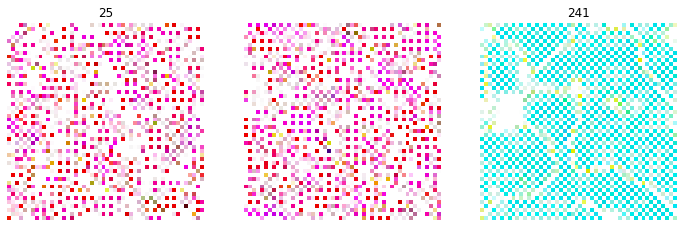




  9%|▊         | 26/300 [00:15<02:37,  1.74it/s]

26 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


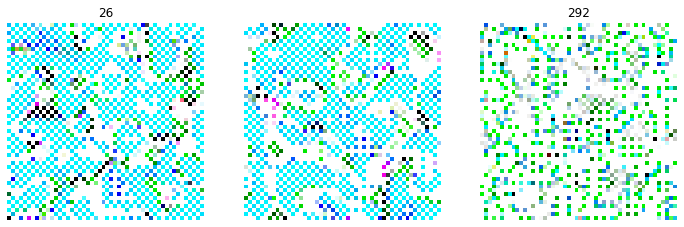




  9%|▉         | 27/300 [00:15<02:36,  1.74it/s]

27 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


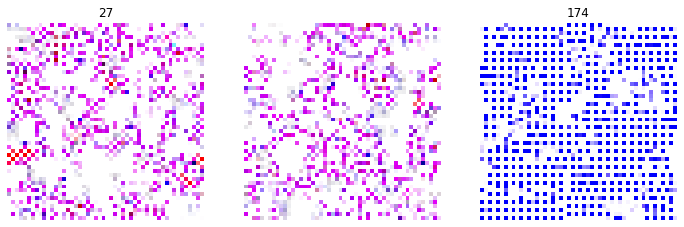




  9%|▉         | 28/300 [00:16<02:36,  1.74it/s]

28 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


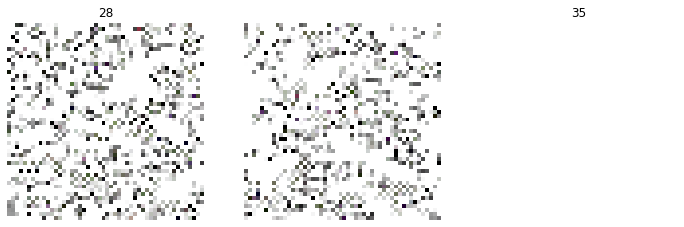




 10%|▉         | 29/300 [00:16<02:35,  1.74it/s]

29 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


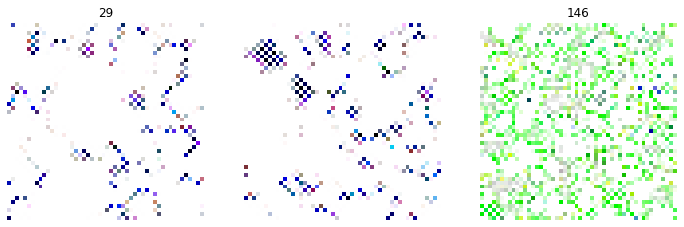




 10%|█         | 30/300 [00:17<02:42,  1.67it/s]

30 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


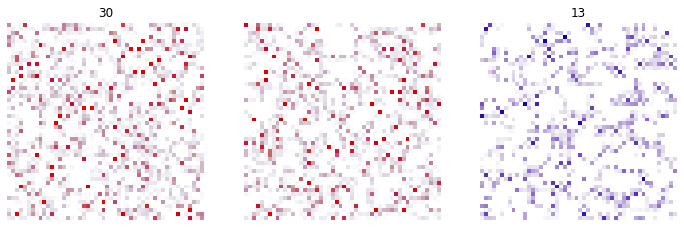




 10%|█         | 31/300 [00:18<02:39,  1.68it/s]

31 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


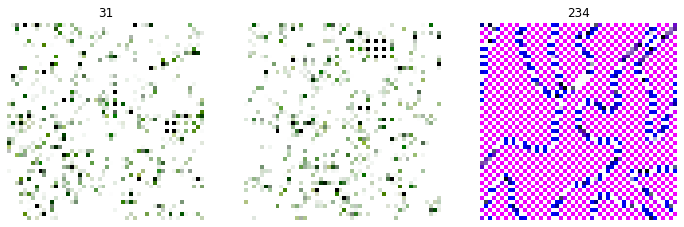




 11%|█         | 32/300 [00:18<02:38,  1.70it/s]

32 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


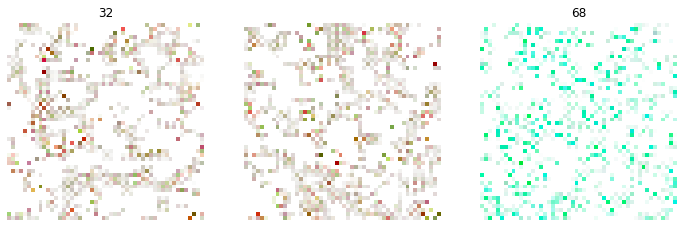




 11%|█         | 33/300 [00:19<02:35,  1.71it/s]

33 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


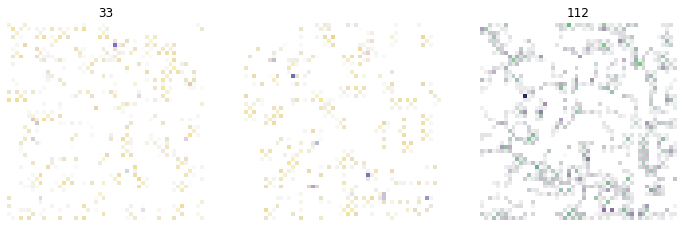




 11%|█▏        | 34/300 [00:19<02:34,  1.72it/s]

34 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


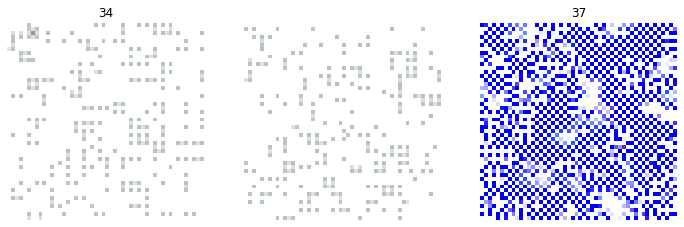




 12%|█▏        | 35/300 [00:20<02:33,  1.73it/s]

35 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


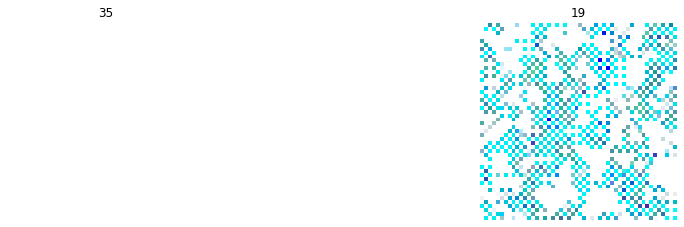




 12%|█▏        | 36/300 [00:20<02:32,  1.73it/s]

36 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


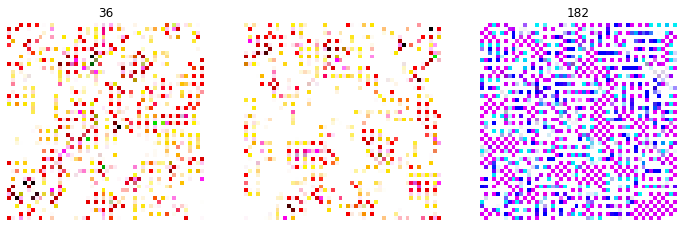




 12%|█▏        | 37/300 [00:21<02:31,  1.73it/s]

37 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


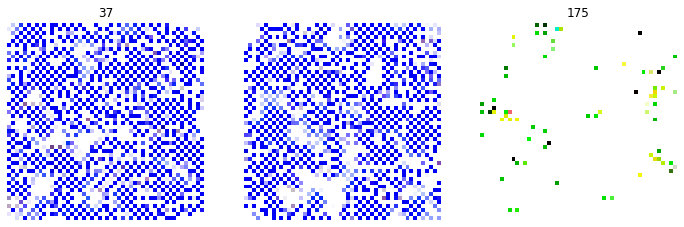




 13%|█▎        | 38/300 [00:22<02:31,  1.73it/s]

38 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


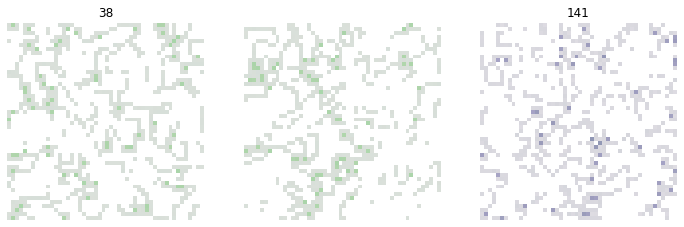




 13%|█▎        | 39/300 [00:22<02:30,  1.74it/s]

39 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


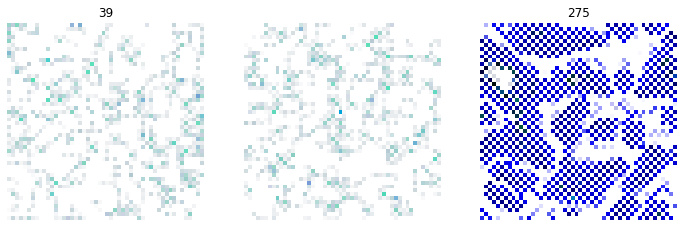




 13%|█▎        | 40/300 [00:23<02:29,  1.74it/s]

40 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


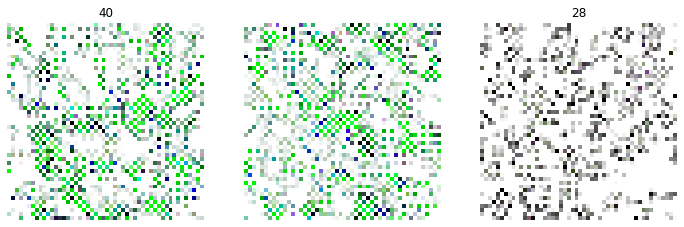




 14%|█▎        | 41/300 [00:23<02:28,  1.74it/s]

41 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


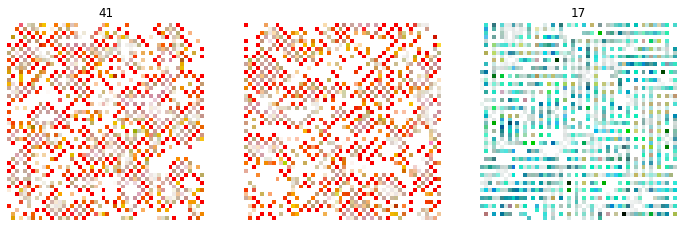




 14%|█▍        | 42/300 [00:24<02:28,  1.74it/s]

42 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


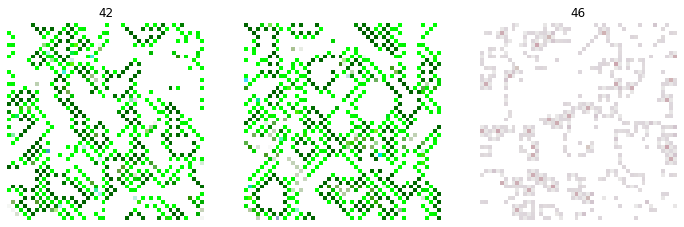




 14%|█▍        | 43/300 [00:24<02:27,  1.74it/s]

43 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


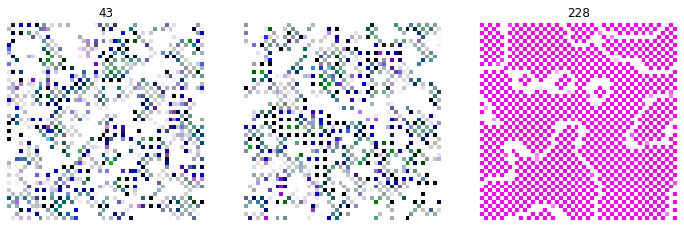




 15%|█▍        | 44/300 [00:25<02:33,  1.67it/s]

44 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


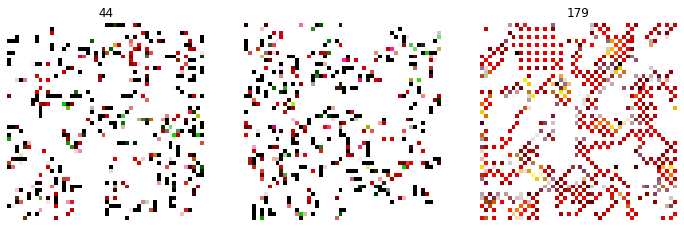




 15%|█▌        | 45/300 [00:26<02:30,  1.69it/s]

45 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


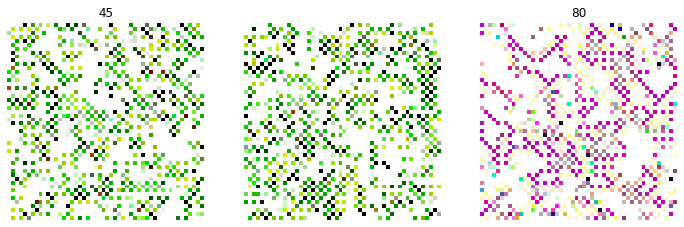




 15%|█▌        | 46/300 [00:26<02:29,  1.70it/s]

46 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


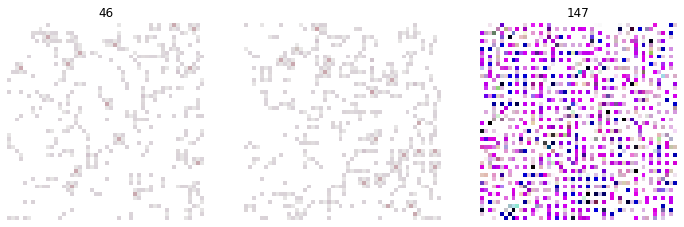




 16%|█▌        | 47/300 [00:27<02:27,  1.72it/s]

47 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


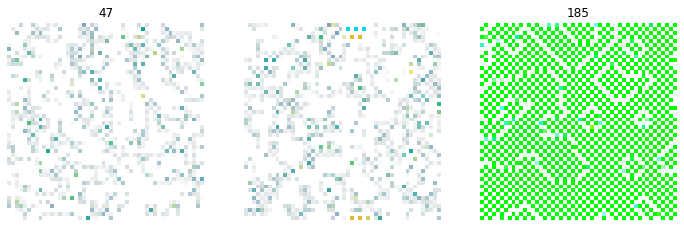




 16%|█▌        | 48/300 [00:27<02:26,  1.72it/s]

48 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


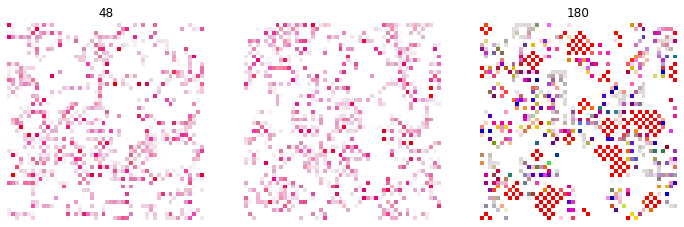




 16%|█▋        | 49/300 [00:28<02:25,  1.73it/s]

49 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


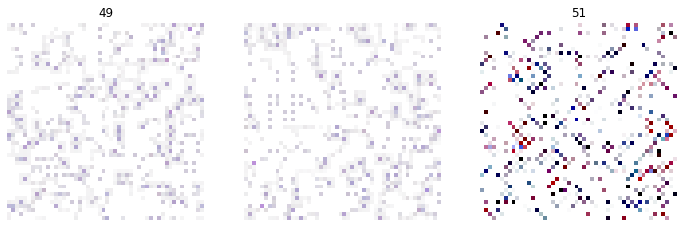




 17%|█▋        | 50/300 [00:29<02:24,  1.73it/s]

50 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


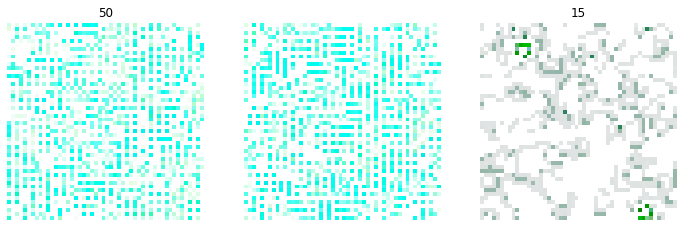




 17%|█▋        | 51/300 [00:29<02:23,  1.74it/s]

51 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


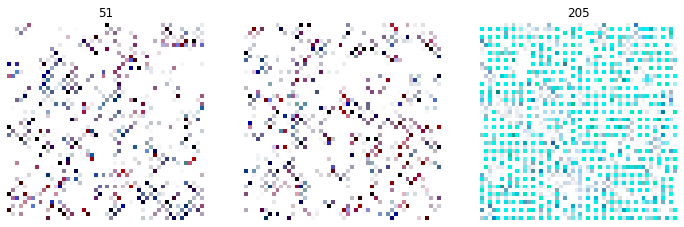




 17%|█▋        | 52/300 [00:30<02:22,  1.74it/s]

52 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


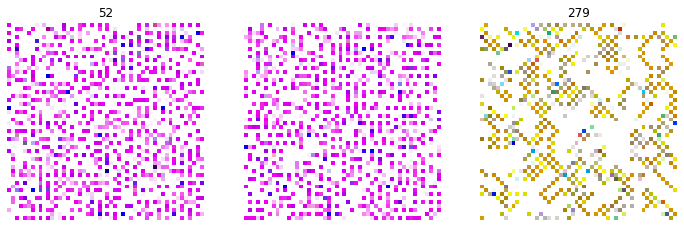




 18%|█▊        | 53/300 [00:30<02:22,  1.74it/s]

53 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


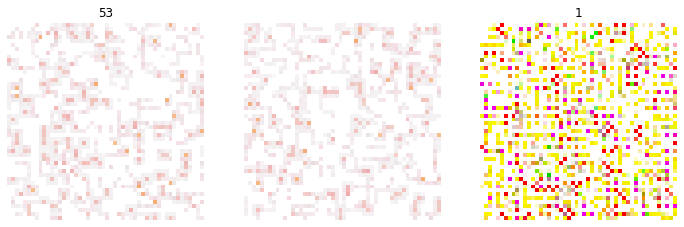




 18%|█▊        | 54/300 [00:31<02:21,  1.74it/s]

54 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


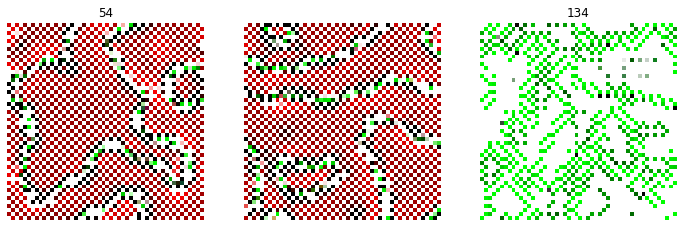




 18%|█▊        | 55/300 [00:31<02:20,  1.74it/s]

55 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


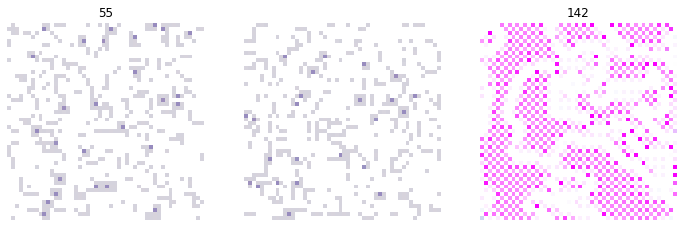




 19%|█▊        | 56/300 [00:32<02:20,  1.74it/s]

56 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


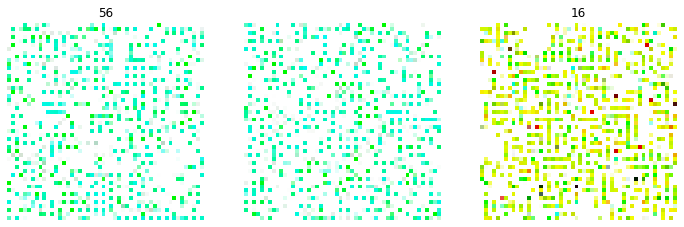




 19%|█▉        | 57/300 [00:33<02:19,  1.74it/s]

57 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


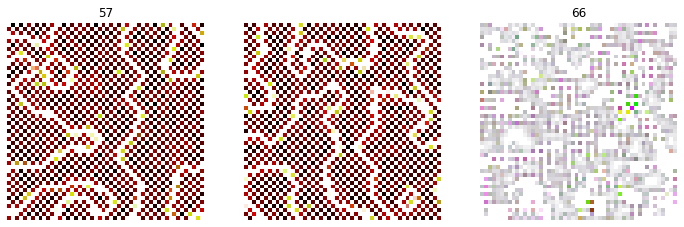




 19%|█▉        | 58/300 [00:33<02:25,  1.66it/s]

58 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


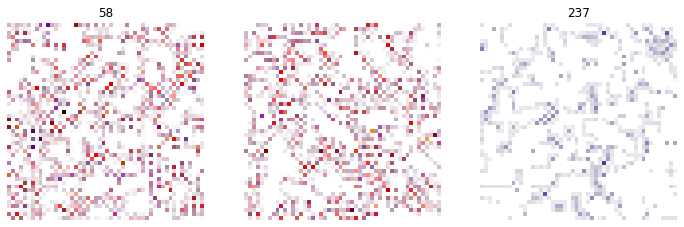




 20%|█▉        | 59/300 [00:34<02:22,  1.69it/s]

59 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


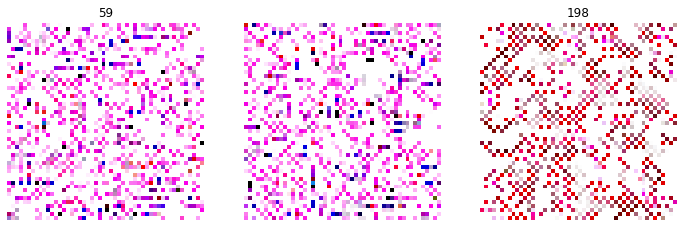




 20%|██        | 60/300 [00:34<02:21,  1.70it/s]

60 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


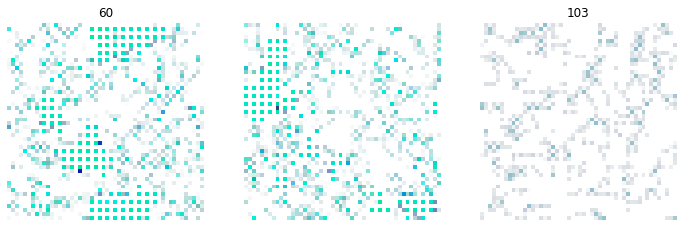




 20%|██        | 61/300 [00:35<02:19,  1.71it/s]

61 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


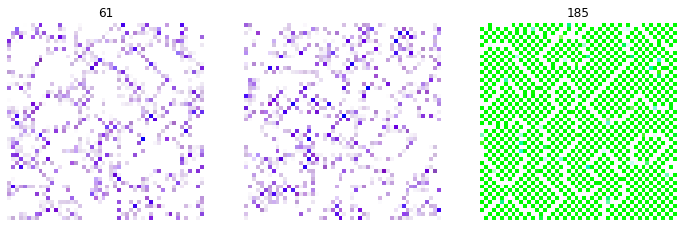




 21%|██        | 62/300 [00:36<02:18,  1.72it/s]

62 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


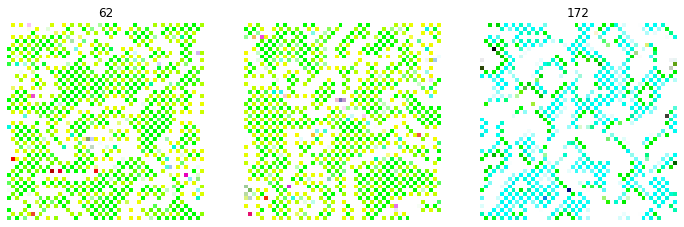




 21%|██        | 63/300 [00:36<02:17,  1.73it/s]

63 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


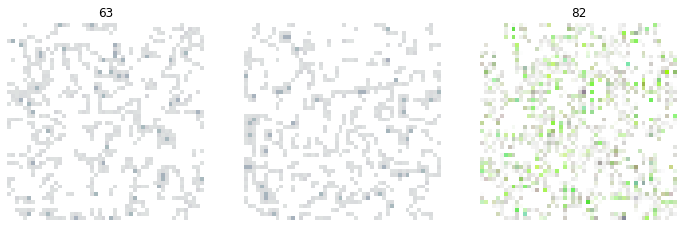




 21%|██▏       | 64/300 [00:37<02:16,  1.73it/s]

64 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


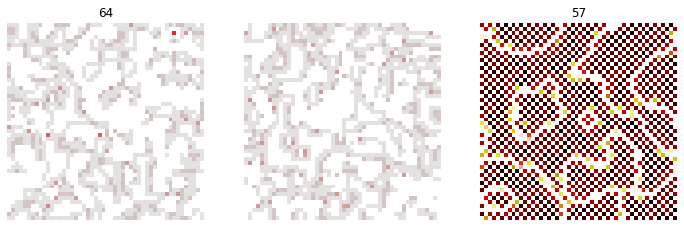




 22%|██▏       | 65/300 [00:37<02:15,  1.74it/s]

65 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


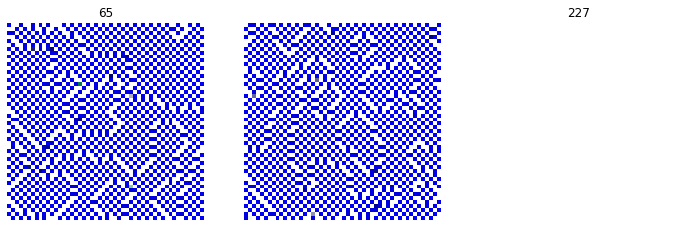




 22%|██▏       | 66/300 [00:38<02:14,  1.73it/s]

66 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


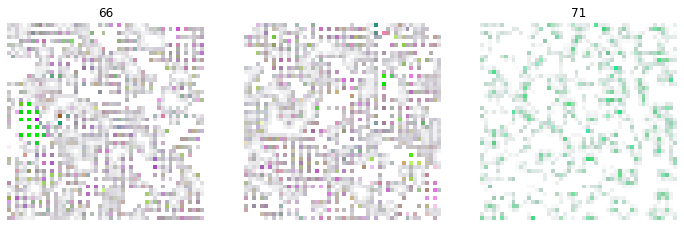




 22%|██▏       | 67/300 [00:38<02:14,  1.74it/s]

67 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


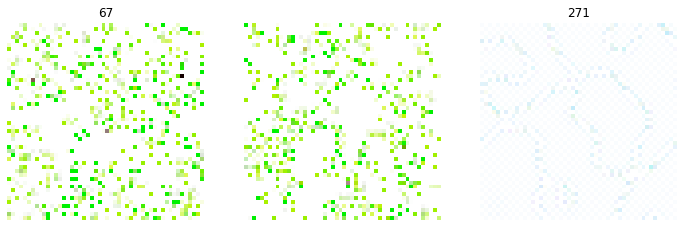




 23%|██▎       | 68/300 [00:39<02:13,  1.73it/s]

68 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


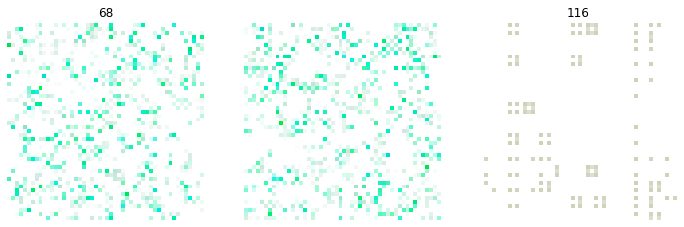




 23%|██▎       | 69/300 [00:40<02:12,  1.74it/s]

69 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


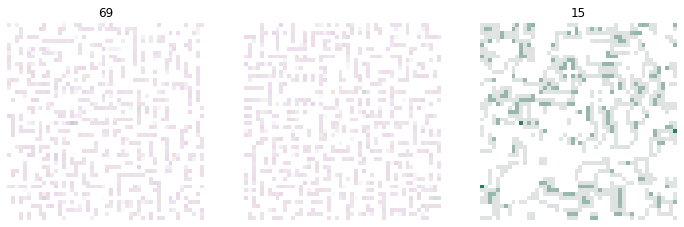




 23%|██▎       | 70/300 [00:40<02:12,  1.74it/s]

70 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


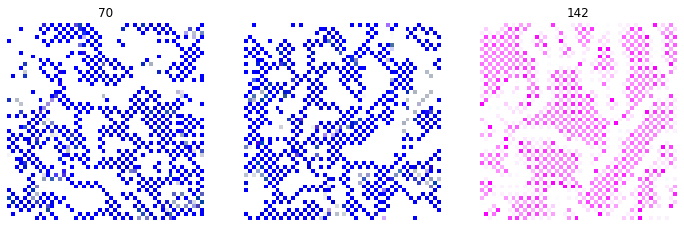




 24%|██▎       | 71/300 [00:41<02:11,  1.74it/s]

71 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


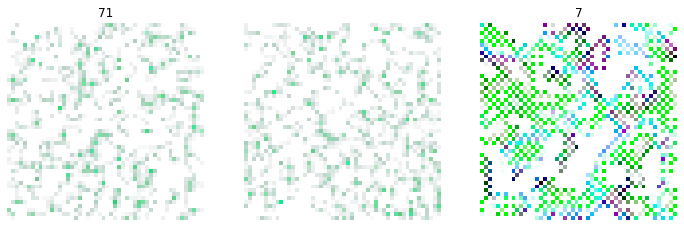




 24%|██▍       | 72/300 [00:41<02:17,  1.66it/s]

72 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


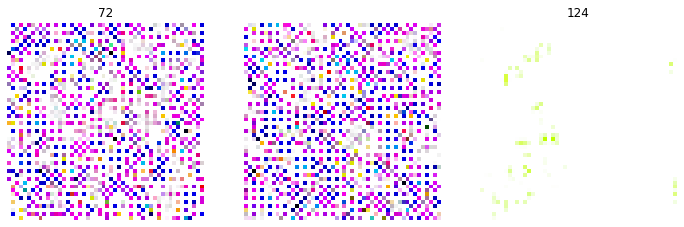




 24%|██▍       | 73/300 [00:42<02:14,  1.69it/s]

73 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


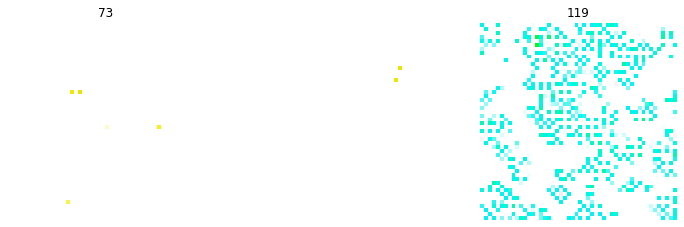




 25%|██▍       | 74/300 [00:43<02:13,  1.69it/s]

74 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


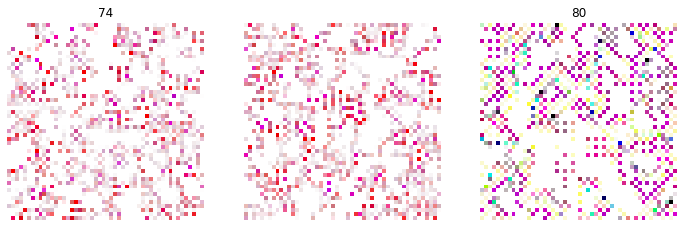




 25%|██▌       | 75/300 [00:43<02:12,  1.70it/s]

75 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


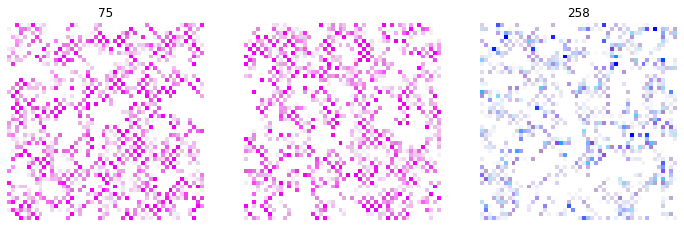




 25%|██▌       | 76/300 [00:44<02:11,  1.70it/s]

76 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


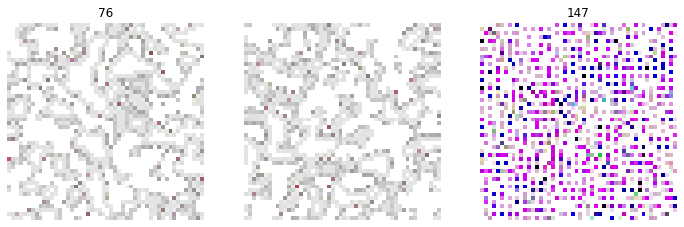




 26%|██▌       | 77/300 [00:44<02:10,  1.71it/s]

77 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


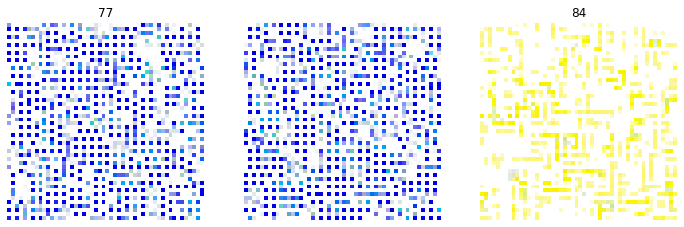




 26%|██▌       | 78/300 [00:45<02:09,  1.71it/s]

78 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


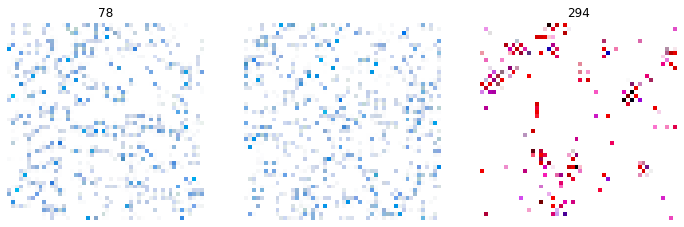




 26%|██▋       | 79/300 [00:45<02:08,  1.71it/s]

79 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


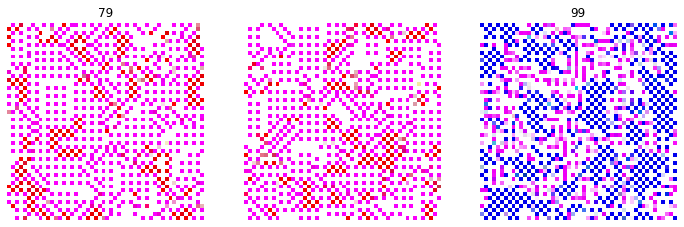




 27%|██▋       | 80/300 [00:46<02:08,  1.71it/s]

80 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


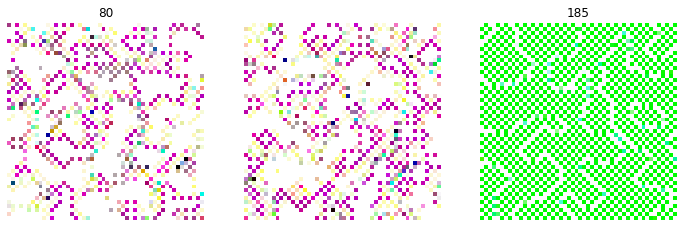




 27%|██▋       | 81/300 [00:47<02:07,  1.72it/s]

81 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


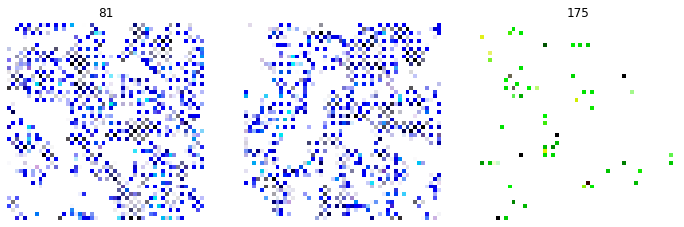




 27%|██▋       | 82/300 [00:47<02:07,  1.71it/s]

82 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


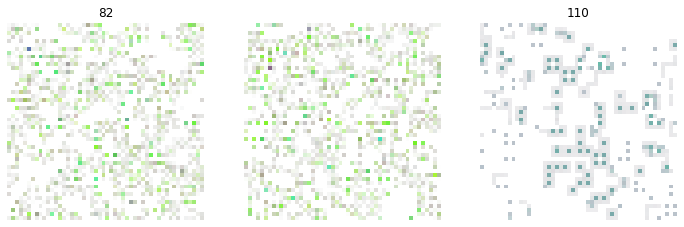




 28%|██▊       | 83/300 [00:48<02:06,  1.72it/s]

83 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


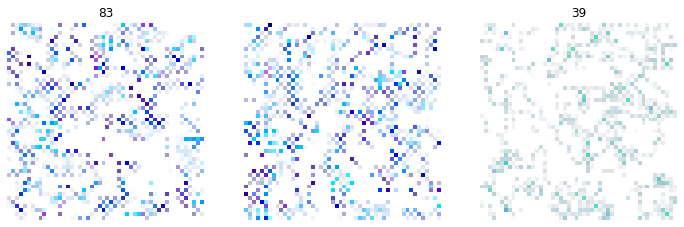




 28%|██▊       | 84/300 [00:48<02:05,  1.72it/s]

84 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


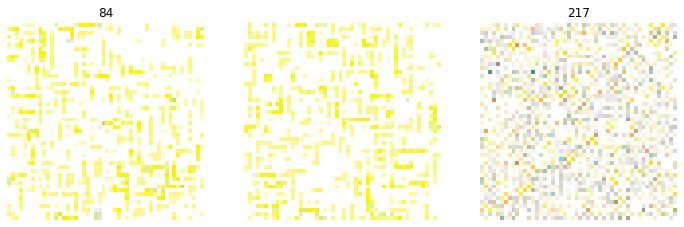




 28%|██▊       | 85/300 [00:49<02:05,  1.72it/s]

85 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


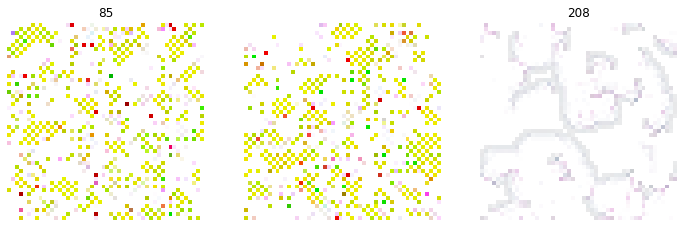




 29%|██▊       | 86/300 [00:50<02:10,  1.64it/s]

86 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


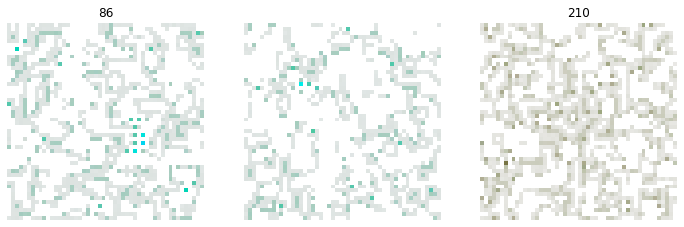




 29%|██▉       | 87/300 [00:50<02:08,  1.66it/s]

87 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


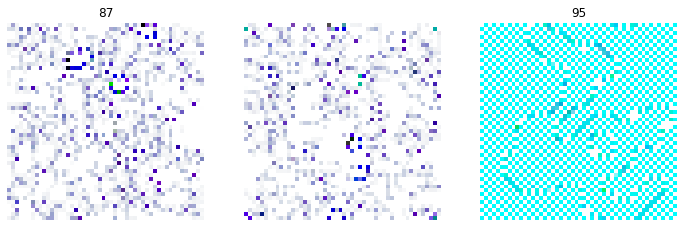




 29%|██▉       | 88/300 [00:51<02:06,  1.67it/s]

88 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


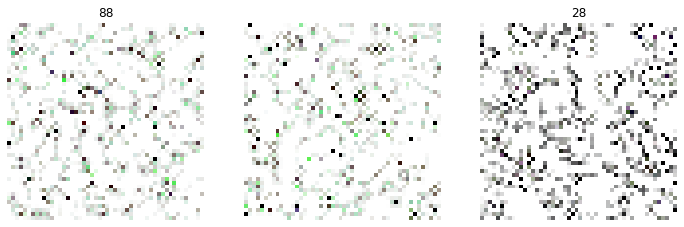




 30%|██▉       | 89/300 [00:51<02:04,  1.69it/s]

89 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


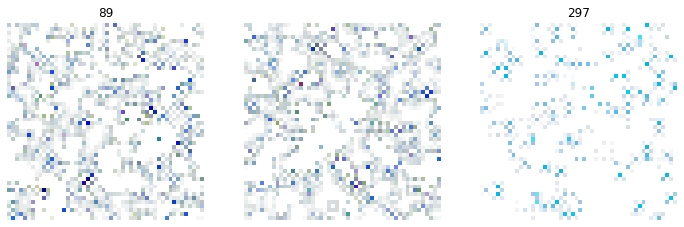




 30%|███       | 90/300 [00:52<02:04,  1.69it/s]

90 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


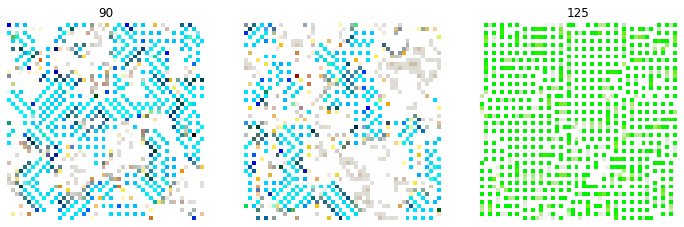




 30%|███       | 91/300 [00:53<02:03,  1.70it/s]

91 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


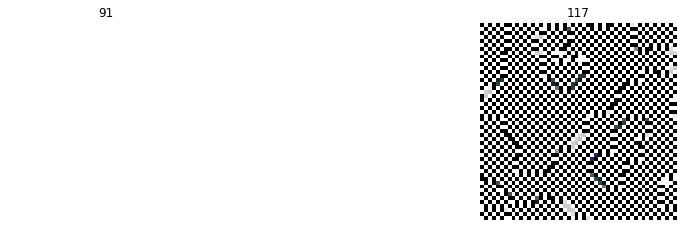




 31%|███       | 92/300 [00:53<02:02,  1.70it/s]

92 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


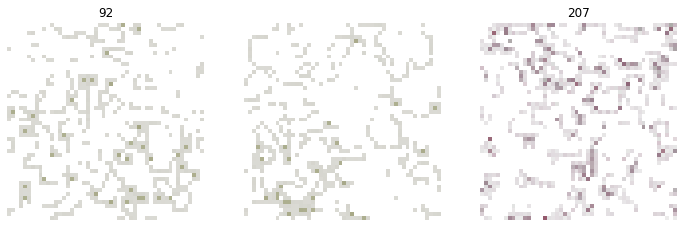




 31%|███       | 93/300 [00:54<02:01,  1.70it/s]

93 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


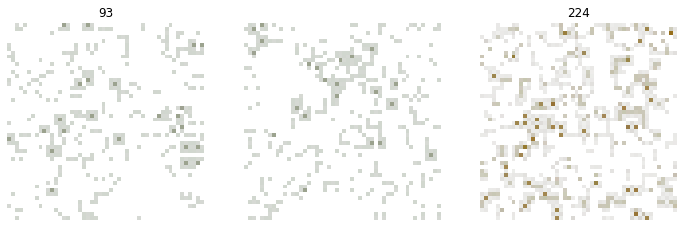




 31%|███▏      | 94/300 [00:54<02:01,  1.70it/s]

94 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


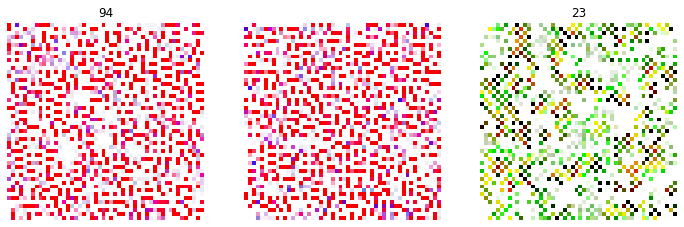




 32%|███▏      | 95/300 [00:55<02:00,  1.70it/s]

95 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


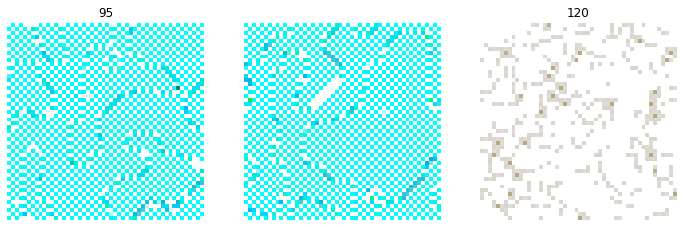




 32%|███▏      | 96/300 [00:55<02:00,  1.70it/s]

96 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


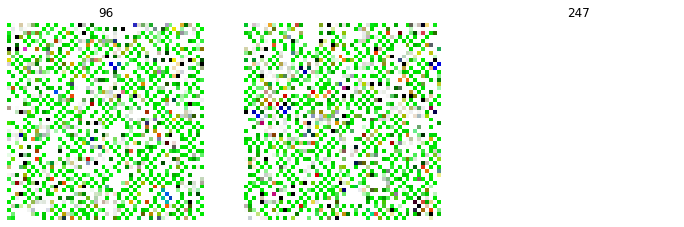




 32%|███▏      | 97/300 [00:56<01:59,  1.70it/s]

97 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


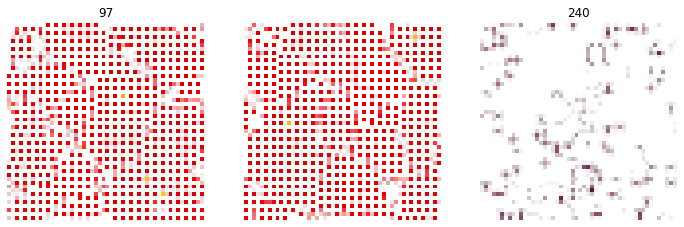




 33%|███▎      | 98/300 [00:57<01:58,  1.70it/s]

98 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


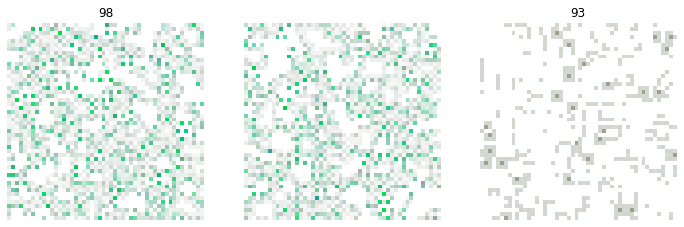




 33%|███▎      | 99/300 [00:57<01:58,  1.70it/s]

99 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


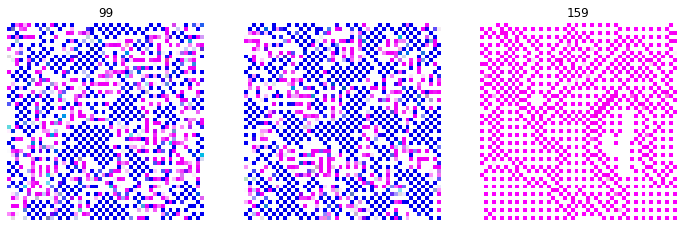




 33%|███▎      | 100/300 [00:58<02:02,  1.63it/s]

100 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


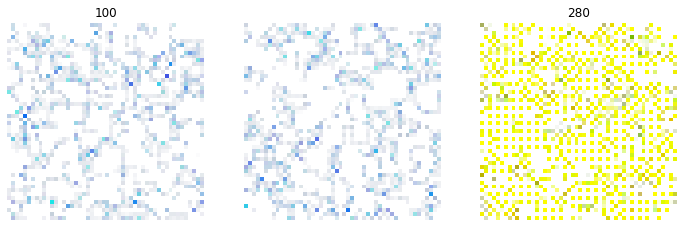




 34%|███▎      | 101/300 [00:59<02:00,  1.65it/s]

101 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


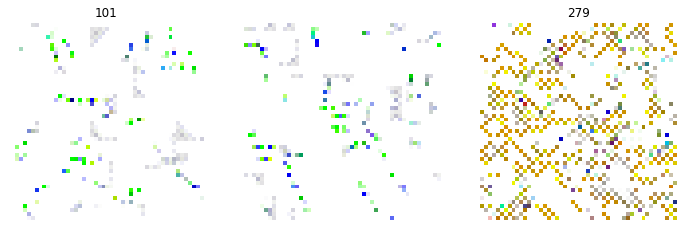




 34%|███▍      | 102/300 [00:59<01:58,  1.66it/s]

102 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


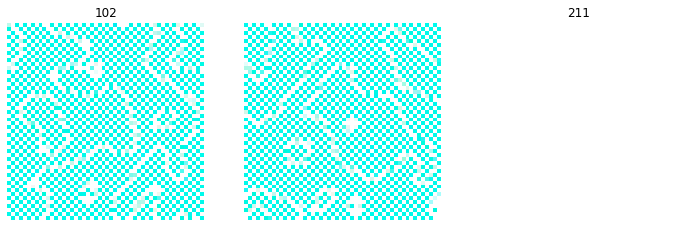




 34%|███▍      | 103/300 [01:00<01:57,  1.68it/s]

103 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


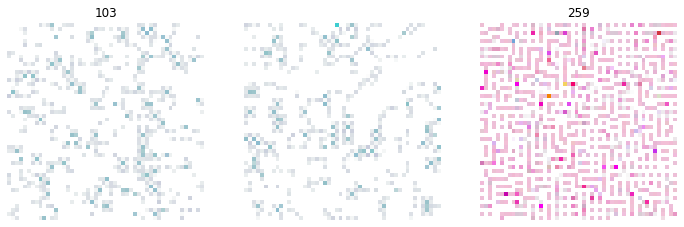




 35%|███▍      | 104/300 [01:00<01:56,  1.68it/s]

104 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


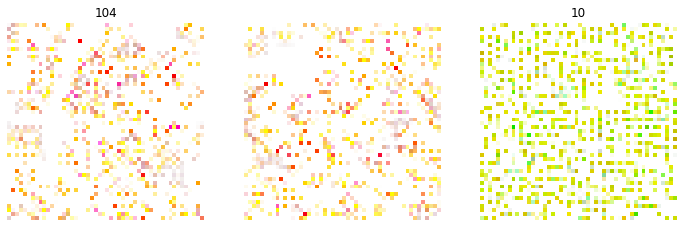




 35%|███▌      | 105/300 [01:01<01:55,  1.69it/s]

105 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


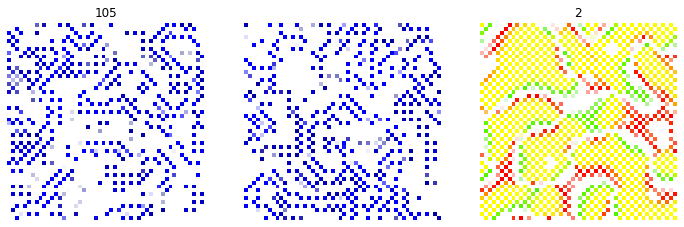




 35%|███▌      | 106/300 [01:01<01:54,  1.70it/s]

106 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


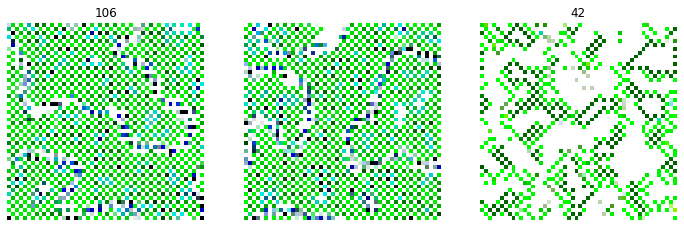




 36%|███▌      | 107/300 [01:02<01:53,  1.70it/s]

107 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


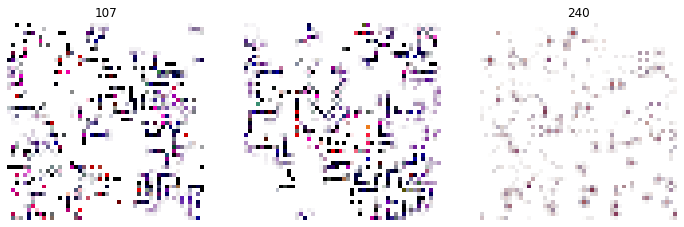




 36%|███▌      | 108/300 [01:03<01:52,  1.70it/s]

108 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


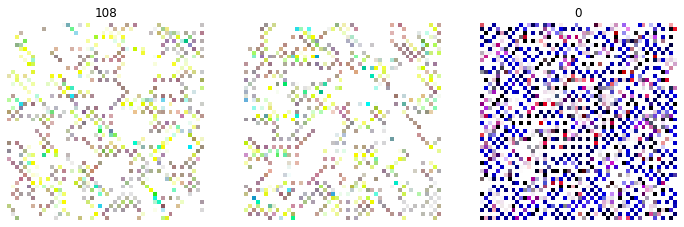




 36%|███▋      | 109/300 [01:03<01:52,  1.70it/s]

109 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


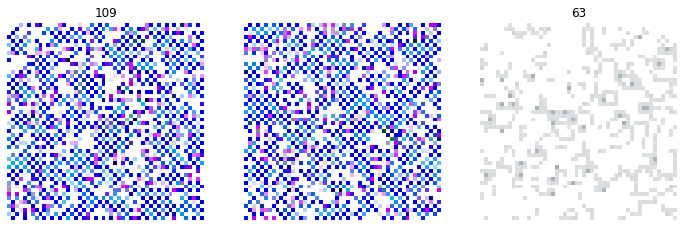




 37%|███▋      | 110/300 [01:04<01:51,  1.70it/s]

110 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


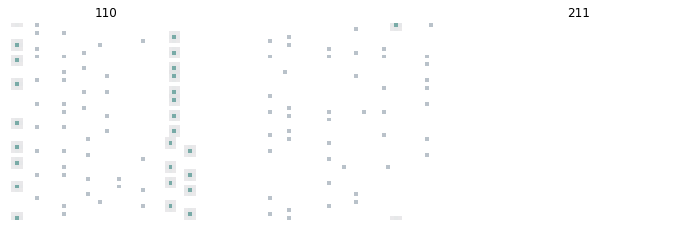




 37%|███▋      | 111/300 [01:04<01:50,  1.71it/s]

111 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


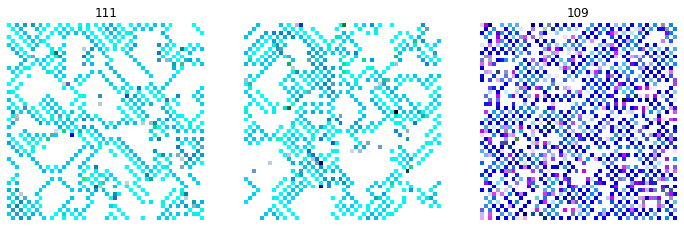




 37%|███▋      | 112/300 [01:05<01:50,  1.70it/s]

112 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


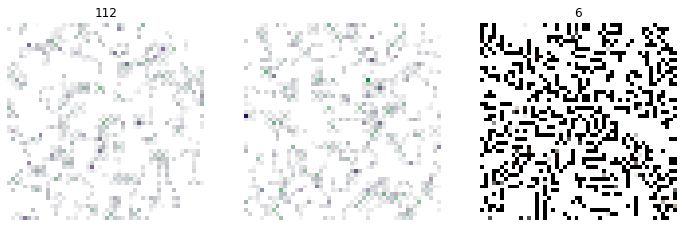




 38%|███▊      | 113/300 [01:06<01:49,  1.71it/s]

113 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


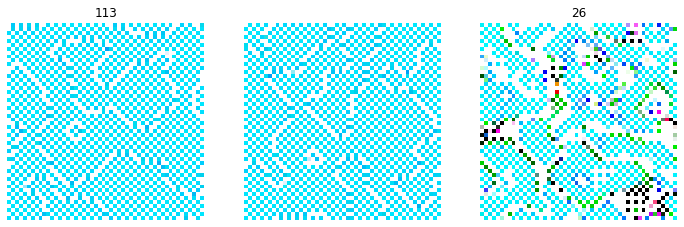




 38%|███▊      | 114/300 [01:06<01:53,  1.63it/s]

114 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


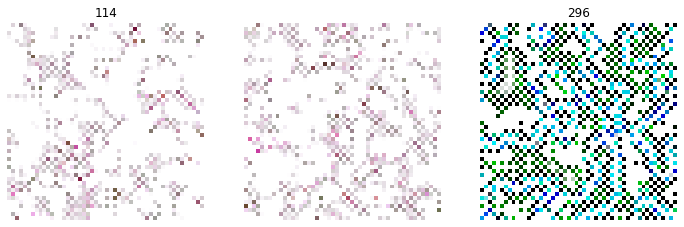




 38%|███▊      | 115/300 [01:07<01:51,  1.66it/s]

115 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


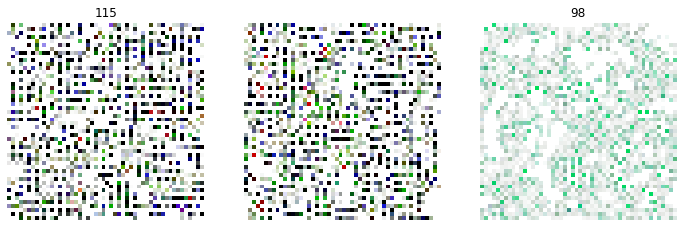




 39%|███▊      | 116/300 [01:07<01:50,  1.67it/s]

116 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


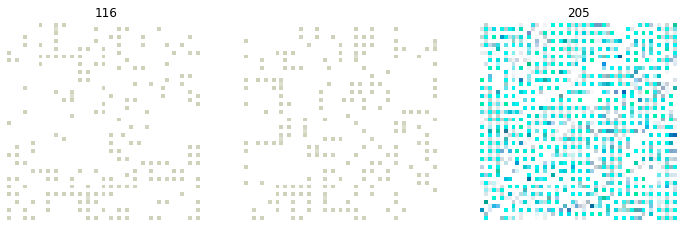




 39%|███▉      | 117/300 [01:08<01:48,  1.68it/s]

117 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


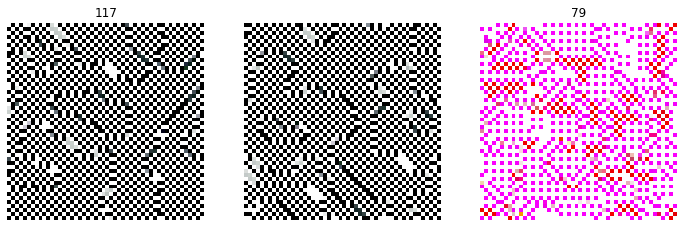




 39%|███▉      | 118/300 [01:09<01:47,  1.69it/s]

118 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


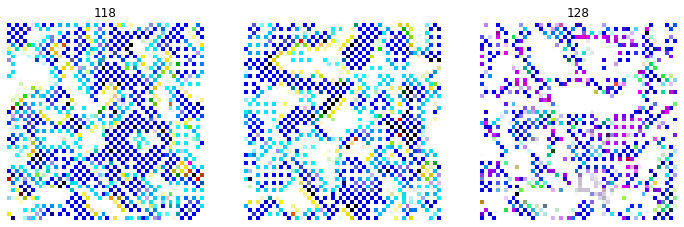




 40%|███▉      | 119/300 [01:09<01:47,  1.69it/s]

119 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


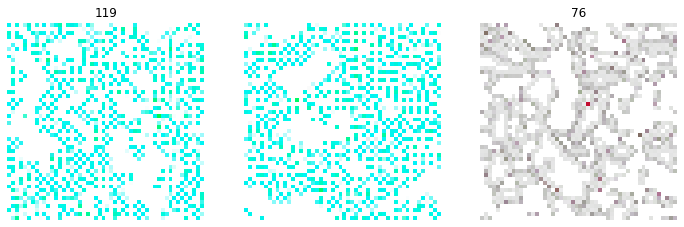




 40%|████      | 120/300 [01:10<01:46,  1.69it/s]

120 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


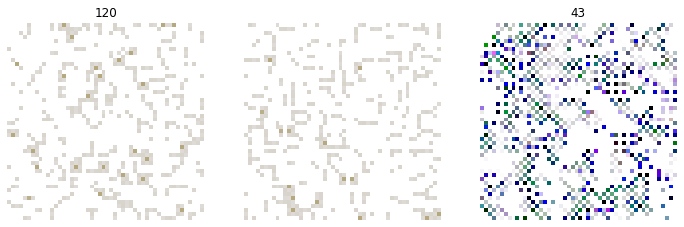




 40%|████      | 121/300 [01:10<01:45,  1.70it/s]

121 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


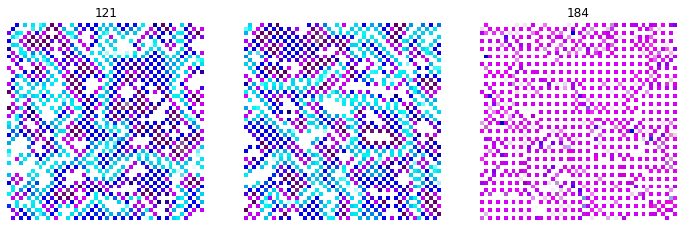




 41%|████      | 122/300 [01:11<01:44,  1.70it/s]

122 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


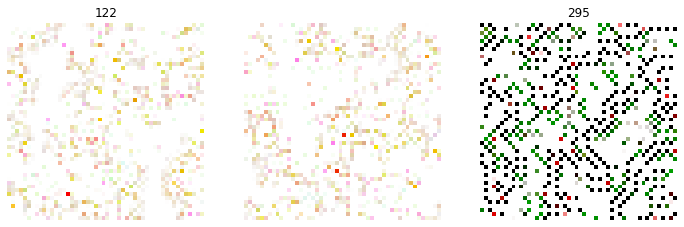




 41%|████      | 123/300 [01:12<01:44,  1.70it/s]

123 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


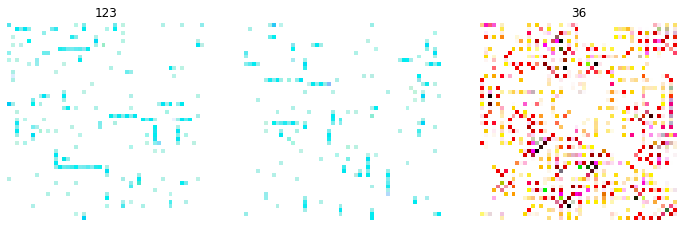




 41%|████▏     | 124/300 [01:12<01:43,  1.70it/s]

124 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


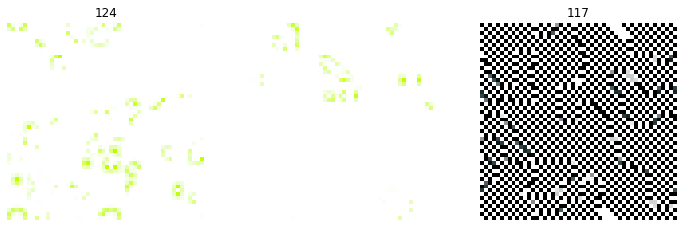




 42%|████▏     | 125/300 [01:13<01:42,  1.71it/s]

125 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


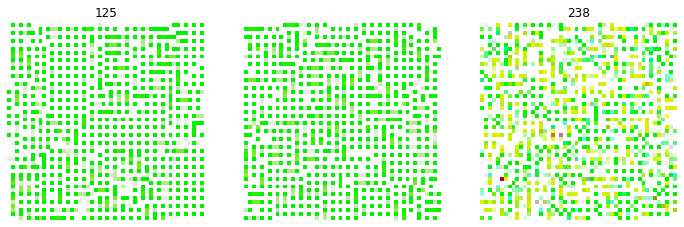




 42%|████▏     | 126/300 [01:13<01:42,  1.70it/s]

126 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


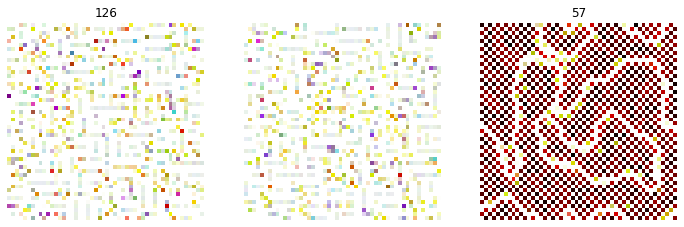




 42%|████▏     | 127/300 [01:14<01:41,  1.70it/s]

127 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


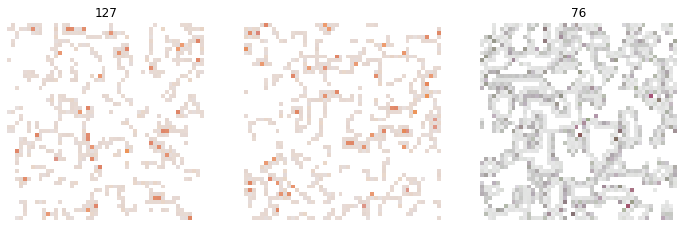




 43%|████▎     | 128/300 [01:15<01:45,  1.63it/s]

128 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


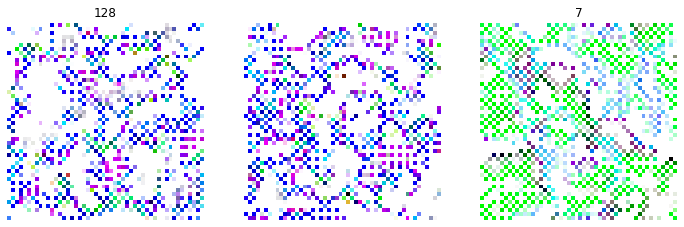




 43%|████▎     | 129/300 [01:15<01:43,  1.65it/s]

129 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


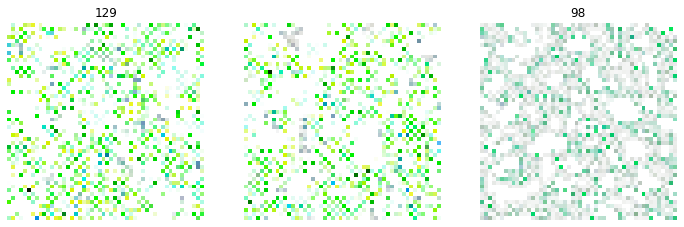




 43%|████▎     | 130/300 [01:16<01:42,  1.66it/s]

130 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


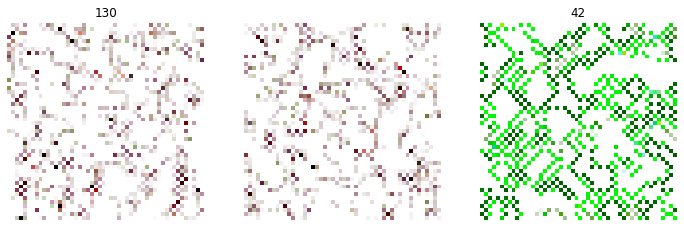




 44%|████▎     | 131/300 [01:16<01:40,  1.68it/s]

131 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


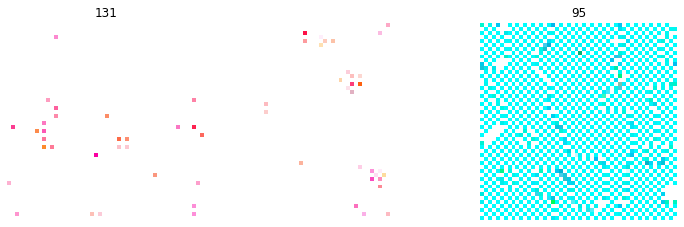




 44%|████▍     | 132/300 [01:17<01:39,  1.68it/s]

132 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


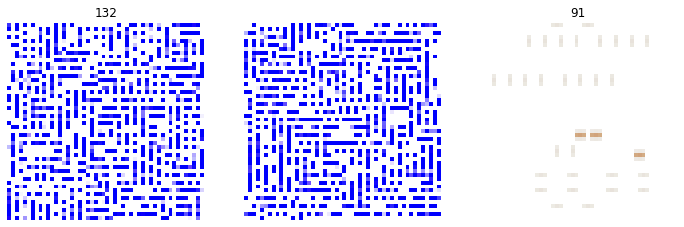




 44%|████▍     | 133/300 [01:17<01:38,  1.69it/s]

133 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


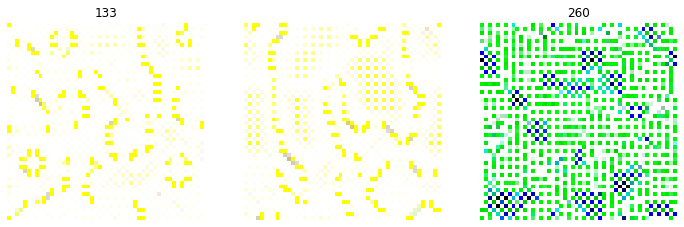




 45%|████▍     | 134/300 [01:18<01:38,  1.69it/s]

134 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


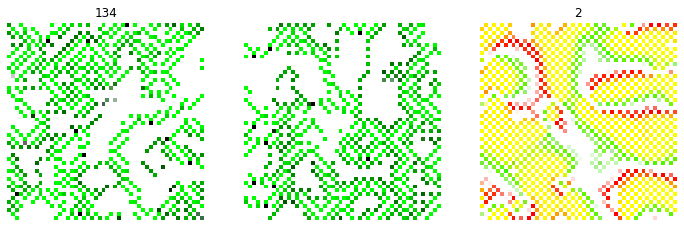




 45%|████▌     | 135/300 [01:19<01:37,  1.70it/s]

135 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


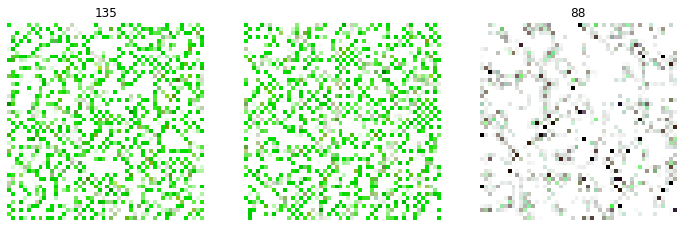




 45%|████▌     | 136/300 [01:19<01:36,  1.69it/s]

136 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


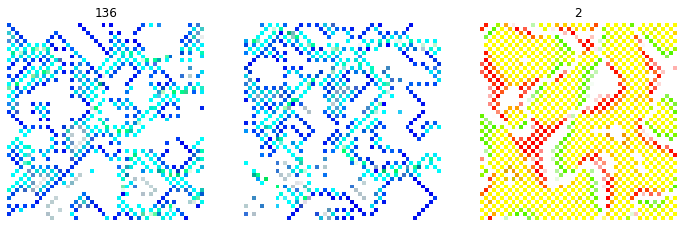




 46%|████▌     | 137/300 [01:20<01:35,  1.70it/s]

137 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


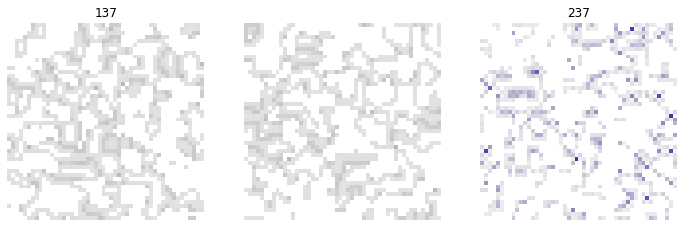




 46%|████▌     | 138/300 [01:20<01:34,  1.71it/s]

138 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


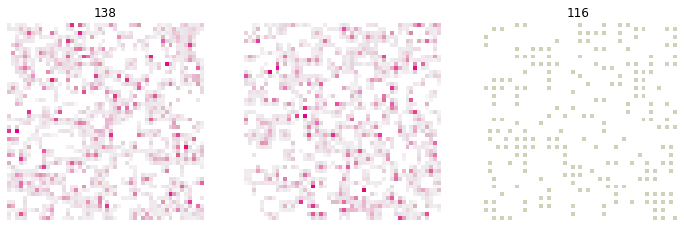




 46%|████▋     | 139/300 [01:21<01:33,  1.72it/s]

139 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


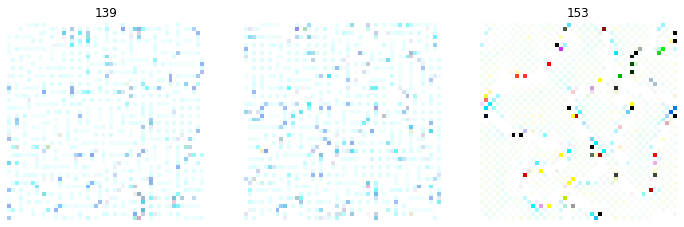




 47%|████▋     | 140/300 [01:22<01:32,  1.72it/s]

140 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


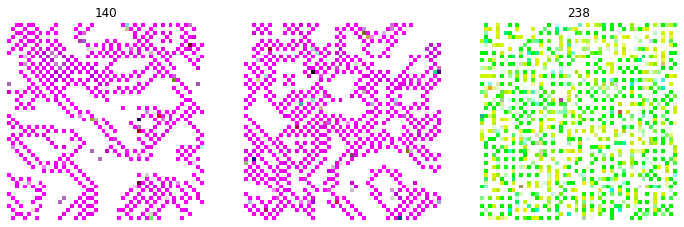




 47%|████▋     | 141/300 [01:22<01:31,  1.73it/s]

141 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


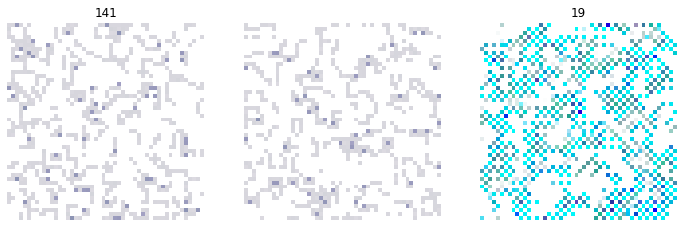




 47%|████▋     | 142/300 [01:23<01:35,  1.66it/s]

142 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


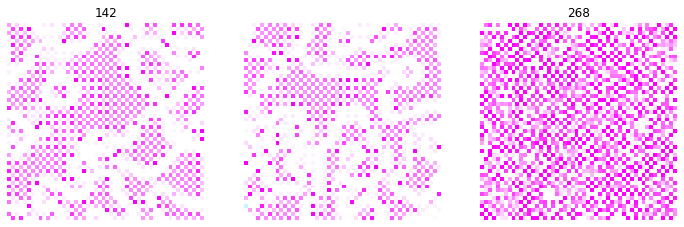




 48%|████▊     | 143/300 [01:23<01:33,  1.68it/s]

143 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


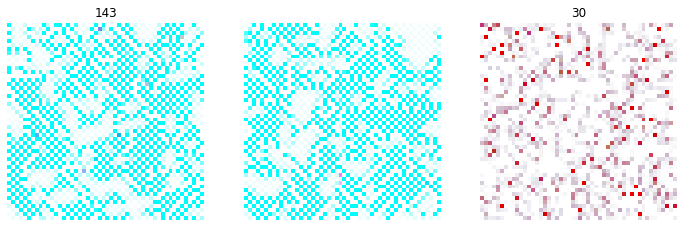




 48%|████▊     | 144/300 [01:24<01:31,  1.70it/s]

144 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


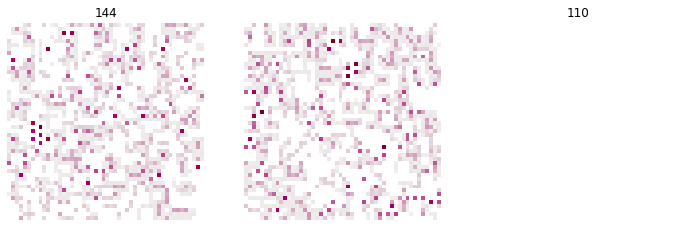




 48%|████▊     | 145/300 [01:25<01:30,  1.71it/s]

145 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


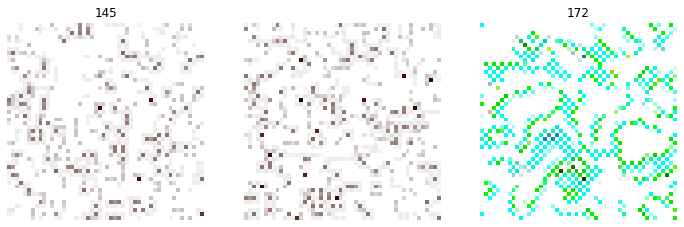




 49%|████▊     | 146/300 [01:25<01:29,  1.72it/s]

146 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


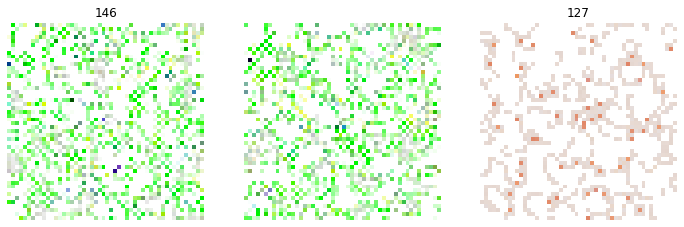




 49%|████▉     | 147/300 [01:26<01:28,  1.72it/s]

147 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


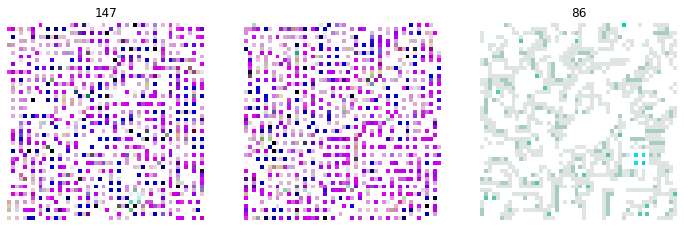




 49%|████▉     | 148/300 [01:26<01:28,  1.73it/s]

148 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


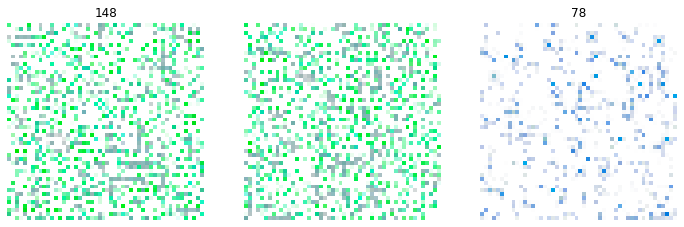




 50%|████▉     | 149/300 [01:27<01:27,  1.73it/s]

149 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


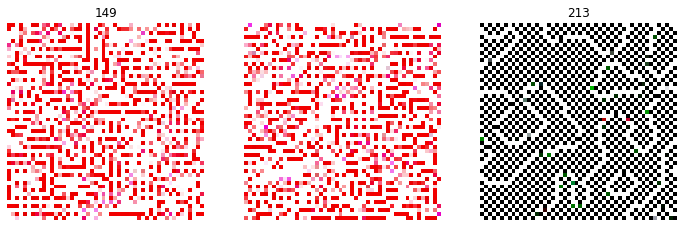




 50%|█████     | 150/300 [01:27<01:26,  1.73it/s]

150 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


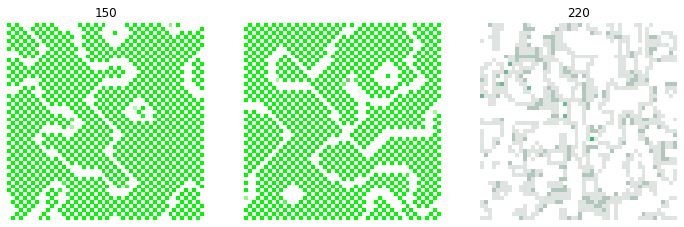




 50%|█████     | 151/300 [01:28<01:25,  1.73it/s]

151 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


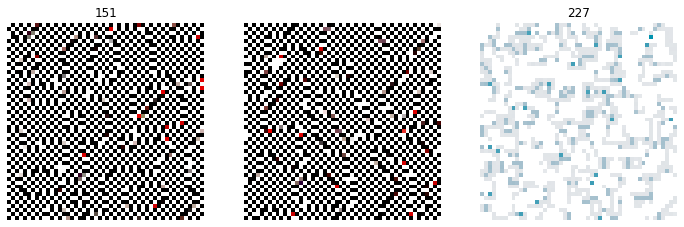




 51%|█████     | 152/300 [01:29<01:25,  1.73it/s]

152 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


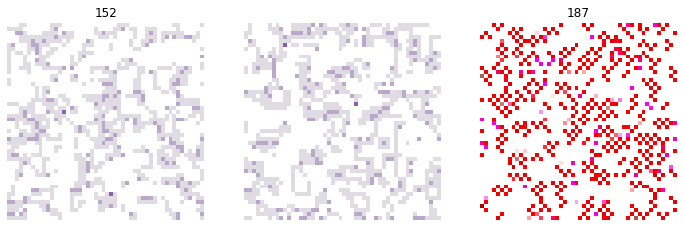




 51%|█████     | 153/300 [01:29<01:24,  1.74it/s]

153 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


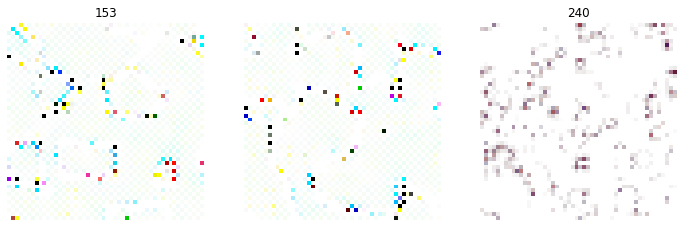




 51%|█████▏    | 154/300 [01:30<01:24,  1.72it/s]

154 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


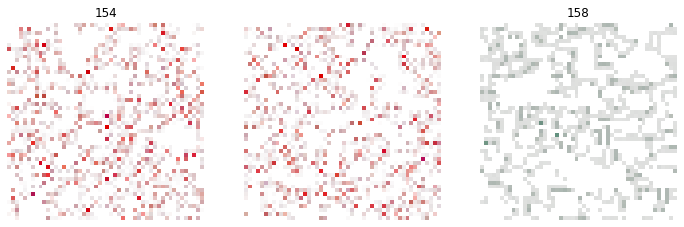




 52%|█████▏    | 155/300 [01:30<01:24,  1.72it/s]

155 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


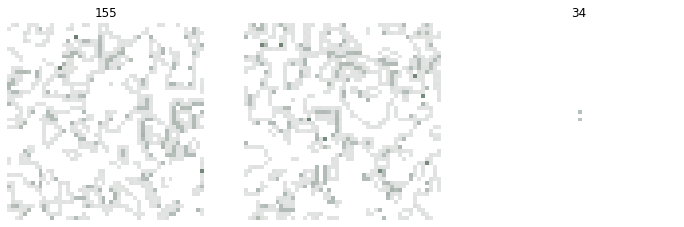




 52%|█████▏    | 156/300 [01:31<01:27,  1.65it/s]

156 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


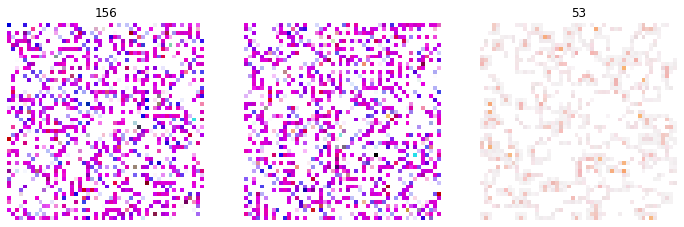




 52%|█████▏    | 157/300 [01:32<01:25,  1.68it/s]

157 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


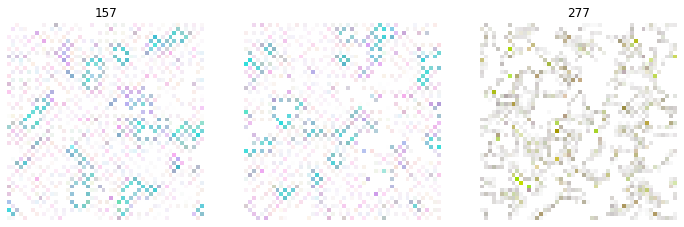




 53%|█████▎    | 158/300 [01:32<01:23,  1.69it/s]

158 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


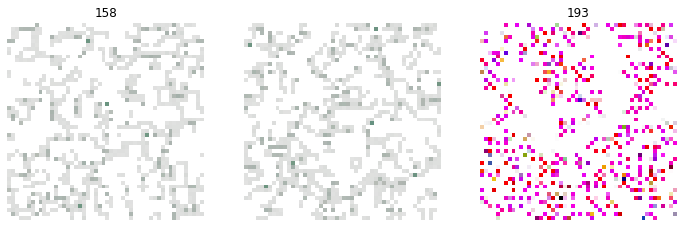




 53%|█████▎    | 159/300 [01:33<01:22,  1.71it/s]

159 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


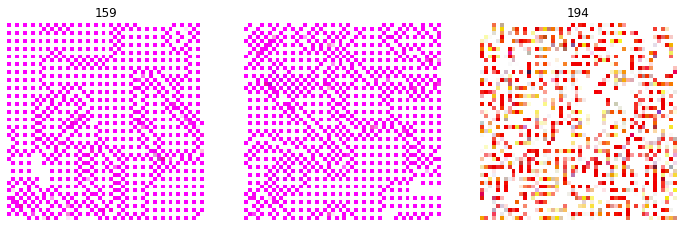




 53%|█████▎    | 160/300 [01:33<01:21,  1.72it/s]

160 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


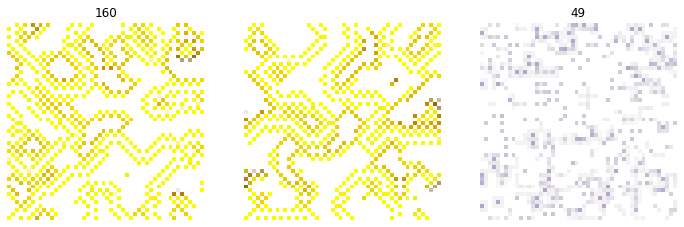




 54%|█████▎    | 161/300 [01:34<01:20,  1.72it/s]

161 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


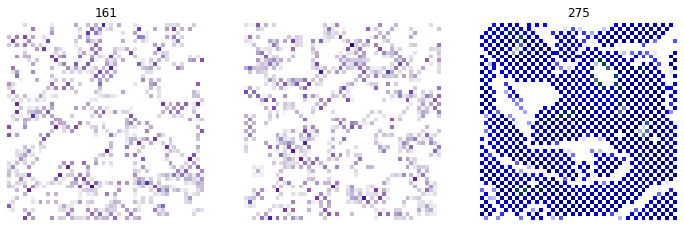




 54%|█████▍    | 162/300 [01:34<01:20,  1.72it/s]

162 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


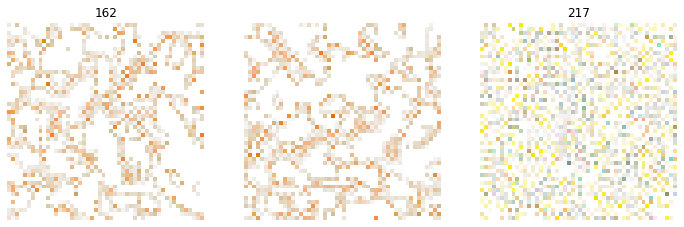




 54%|█████▍    | 163/300 [01:35<01:19,  1.73it/s]

163 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


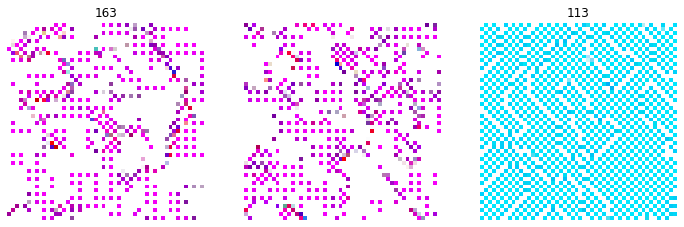




 55%|█████▍    | 164/300 [01:36<01:18,  1.73it/s]

164 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


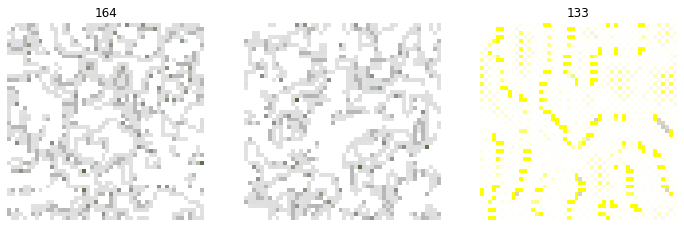




 55%|█████▌    | 165/300 [01:36<01:17,  1.73it/s]

165 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


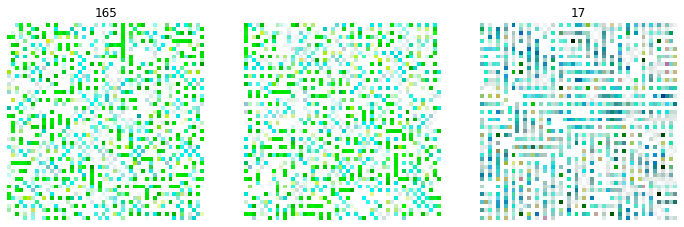




 55%|█████▌    | 166/300 [01:37<01:17,  1.73it/s]

166 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


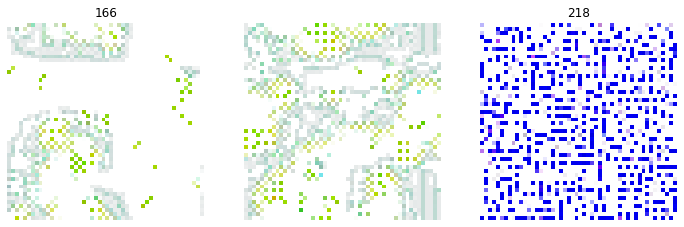




 56%|█████▌    | 167/300 [01:37<01:16,  1.73it/s]

167 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


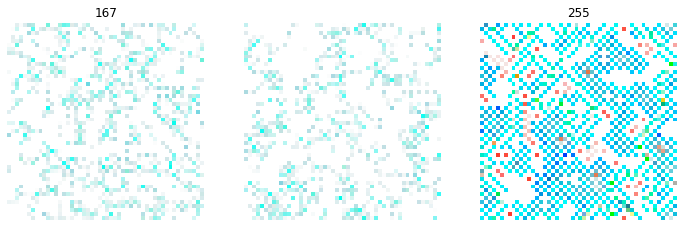




 56%|█████▌    | 168/300 [01:38<01:16,  1.73it/s]

168 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


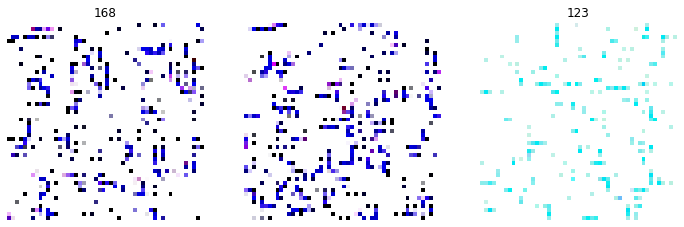




 56%|█████▋    | 169/300 [01:38<01:15,  1.74it/s]

169 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


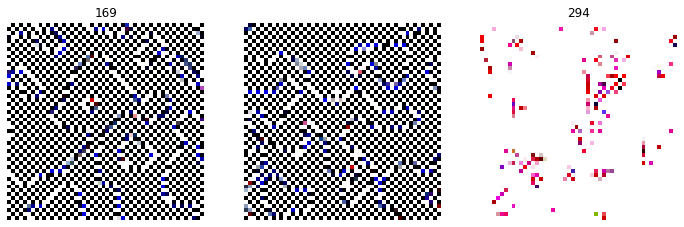




 57%|█████▋    | 170/300 [01:39<01:18,  1.66it/s]

170 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


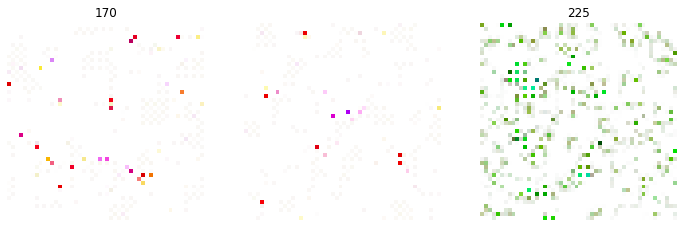




 57%|█████▋    | 171/300 [01:40<01:16,  1.68it/s]

171 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


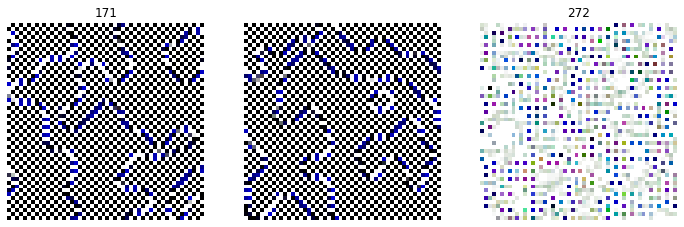




 57%|█████▋    | 172/300 [01:40<01:15,  1.70it/s]

172 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


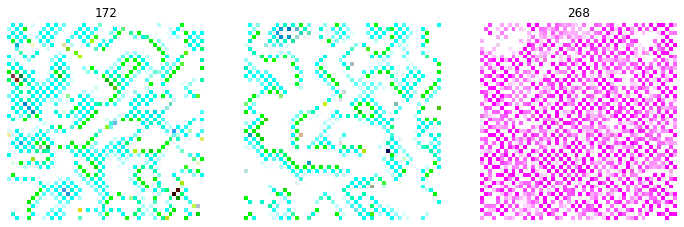




 58%|█████▊    | 173/300 [01:41<01:14,  1.71it/s]

173 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


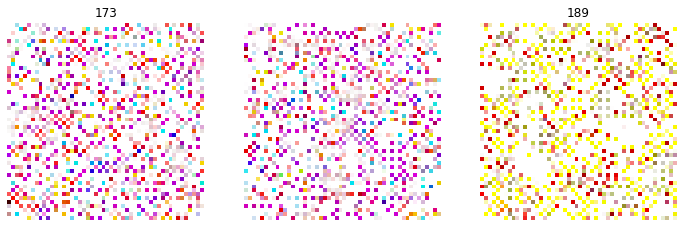




 58%|█████▊    | 174/300 [01:41<01:13,  1.71it/s]

174 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


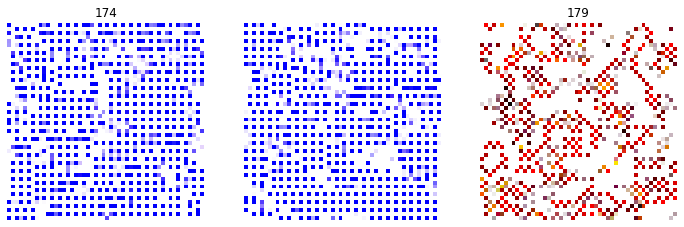




 58%|█████▊    | 175/300 [01:42<01:12,  1.72it/s]

175 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


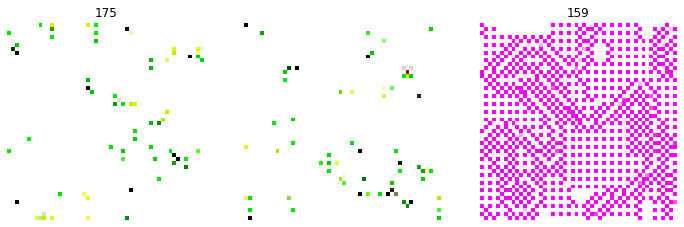




 59%|█████▊    | 176/300 [01:43<01:11,  1.72it/s]

176 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


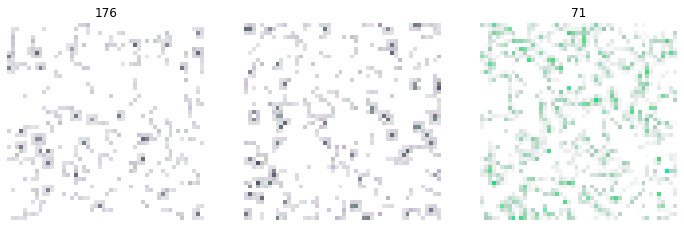




 59%|█████▉    | 177/300 [01:43<01:11,  1.73it/s]

177 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


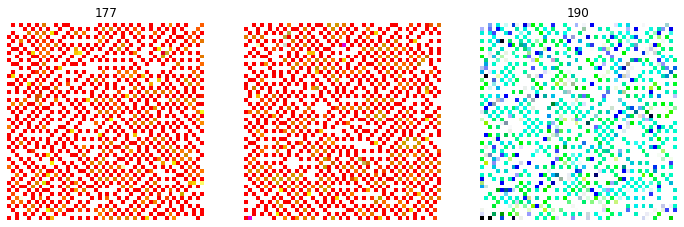




 59%|█████▉    | 178/300 [01:44<01:10,  1.73it/s]

178 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


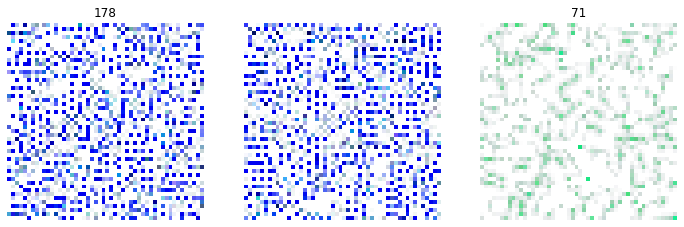




 60%|█████▉    | 179/300 [01:44<01:09,  1.74it/s]

179 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


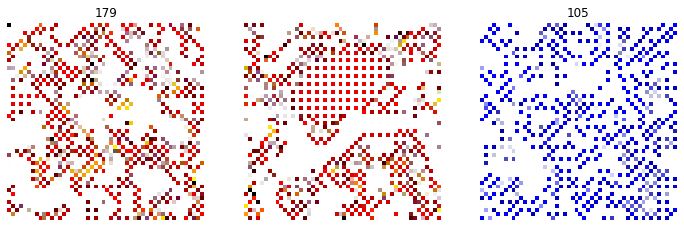




 60%|██████    | 180/300 [01:45<01:09,  1.73it/s]

180 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


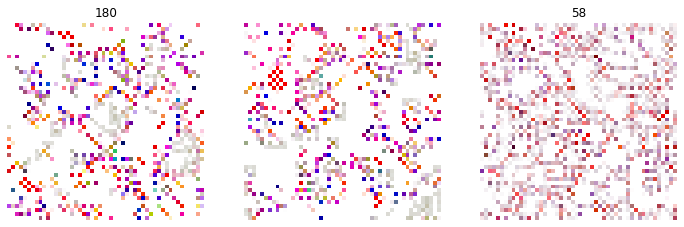




 60%|██████    | 181/300 [01:45<01:08,  1.74it/s]

181 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


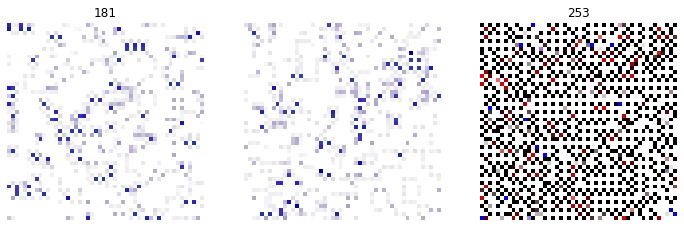




 61%|██████    | 182/300 [01:46<01:08,  1.73it/s]

182 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


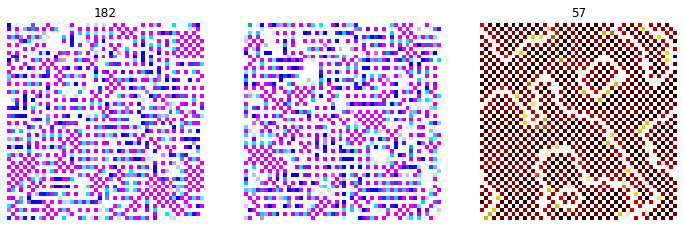




 61%|██████    | 183/300 [01:47<01:07,  1.74it/s]

183 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


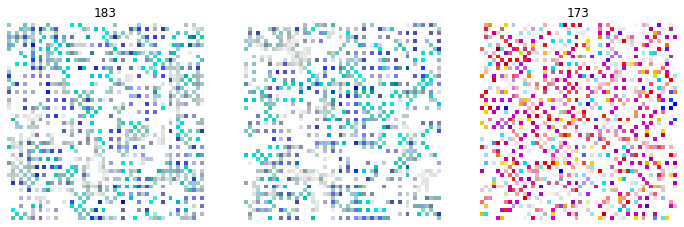




 61%|██████▏   | 184/300 [01:47<01:09,  1.66it/s]

184 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


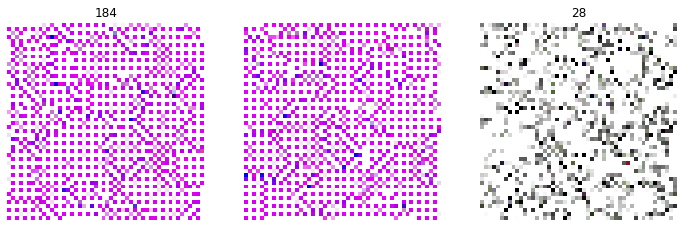




 62%|██████▏   | 185/300 [01:48<01:08,  1.69it/s]

185 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


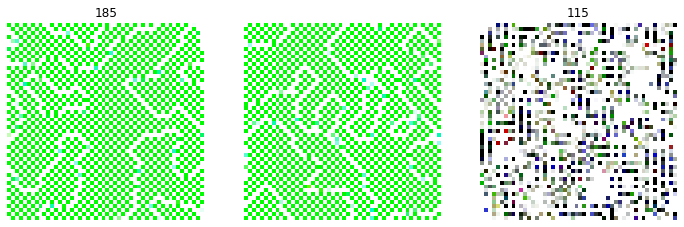




 62%|██████▏   | 186/300 [01:48<01:07,  1.70it/s]

186 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


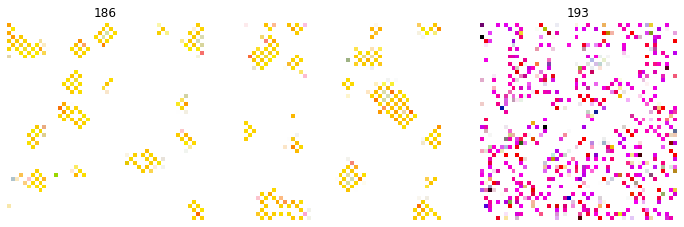




 62%|██████▏   | 187/300 [01:49<01:05,  1.71it/s]

187 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


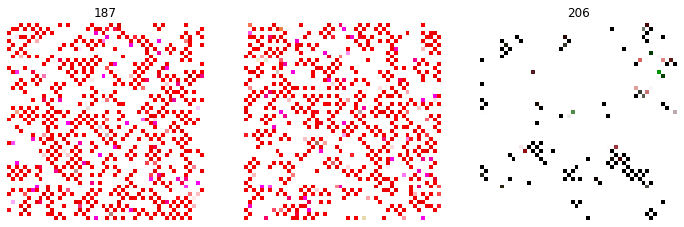




 63%|██████▎   | 188/300 [01:50<01:05,  1.72it/s]

188 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


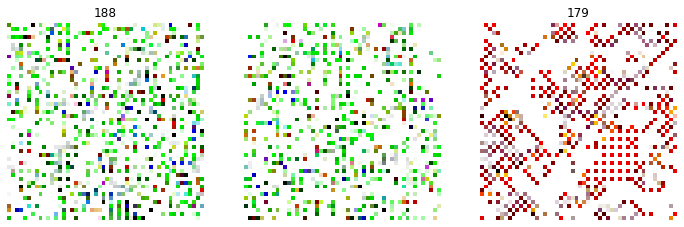




 63%|██████▎   | 189/300 [01:50<01:04,  1.73it/s]

189 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


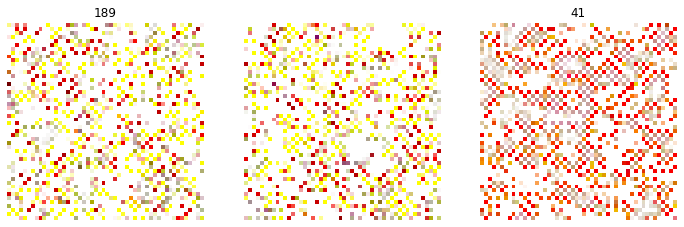




 63%|██████▎   | 190/300 [01:51<01:03,  1.73it/s]

190 Max. gradient: 0.000000e+00, Tloss: 0.000000e+00


In [ ]:
res = 50
epochs = 1000
step_size = 1
fire_rate = 1
save = False

emb_loss = []
total_dists = []
mean_grads = []
hard_negative_sum = []
hard_frac = []

index_list = np.arange(len(CAs))

if save:
    folder = f'models/model_N_{NUM_POP}_' + time.strftime("%Y%m%d-%H%M%S")
    makedirs(folder)
    PATH = path.join(folder, 'epoch_' + str(0).zfill(4) + '.tar')
    
    copy_notebook(folder)
    torch.save({
        'epoch': 0,
        'model_state_dict': [CA.state_dict() for CA in CAs],
        'optimizer_state_dict': [optim.state_dict() for optim in Optims_CAs],
        'embedder_state_dict': embed.state_dict(),
        'embedder_optimizer_state_dict': optim_emb.state_dict(),
        'loss': None,
        'stats': None
    }, PATH)


for epoch in tqdm(range(epochs)):
    
    clear_output(wait=True)
    total_loss = 0
    
    zs_1 = []
    zs_2 = []
    
    if epoch > 1:
        fig, ax = plt.subplots(2, 3, figsize=(12,6))
        ax[0, 0].plot(emb_loss, '.-', label='Tloss')
        ax[0, 1].plot(mean_grads, '.-', label='AvgGrad')
        ax[0, 2].plot(np.log10(total_dists), '.-', label='Sum of distances')
        ax[1, 0].plot(hard_negative_sum, '.-', label='Hard negtive mining sum')
        ax[1, 2].plot(hard_frac, '.-', label='Hard negative fraction')
        
        [a.legend() for i, a in enumerate(ax.flatten()) if i != 4]
        
        fig.suptitle(f'Epoch: {epoch}')
        
        plt.show()
        
        if epoch % 10 == 0:
            
            stats = {
                'hneg_sum': hard_negative_sum,
                'hfrac': hard_frac,
                'mean_grad': mean_grads,
                'total_dists': total_dists
            }
            
            PATH = path.join(folder, 'epoch_' + str(epoch).zfill(4) + '.tar')
            
            torch.save({
                'epoch': epoch,
                'model_state_dict': [CA.state_dict() for CA in CAs],
                'optimizer_state_dict': [optim.state_dict() for optim in Optims_CAs],
                'embedder_state_dict': embed.state_dict(),
                'embedder_optimizer_state_dict': optim_emb.state_dict(),
                'loss': emb_loss,
                'stats': stats
            }, PATH)

    for CA_i in tqdm(range(len(CAs))):
        # pick most similar or random other CA
        if epoch == 0:
            # pick a random other CA
            CA_B_i = np.random.permutation(index_list[index_list != CA_i])[0]
            CA_B = CAs[CA_B_i]
            CA_A = CAs[CA_i]
        else:
            # find the top-k most similar CA and compare vs. that            
            
            CA_i_zstats = [item for item in tloss_prev if item[0]==CA_i]
            B_idxs = [item[1] for item in CA_i_zstats]
            k = len(CA_i_zstats)  # number of other CAs to compare to (change beta if you increase/decrease k)
            z_dists, nearest = torch.topk(torch.stack([item[2] for item in CA_i_zstats]), k=k)  # get the CAs that are most similar to CA_i
            # CA_B_i = B_idxs[nearest.cpu().detach().numpy()[0]]  # if k==1
            # CA_B_i = B_idxs[nearest[torch.randint(nearest.shape[0], (1,))].cpu().detach().numpy()[0]]            
            beta = 2
            p = F.softmax(beta*z_dists, dim=0).cpu().detach().numpy()
            CA_B_i = B_idxs[np.random.choice(nearest.cpu().detach().numpy(), p=p)] 
            
            # check for dead/frozen CAs, re-initialize if so (checks last 3 embeddings for differences)
            lookback_time = 3
            check_dead_A = (np.diff(zs_prev[CA_i].reshape(-1, 8).cpu().detach().numpy(), axis=0)).sum(axis=1)[-lookback_time:].sum() == 0
#             check_dead_B = (np.diff(zs_prev[CA_B_i].reshape(-1, 8).cpu().detach().numpy(), axis=0)).sum(axis=1)[-lookback_time:].sum() == 0
            
            if check_dead_A:
                CAs[CA_i] = CAModel().cuda()
                Optims_CAs[CA_i] = torch.optim.Adam([p for p in CAs[CA_i].parameters()], lr=1e-3)
                print(f'CA {CA_i} is dead. Reinitializing.')
#             if check_dead_B:
#                 CAs[CA_B_i] = CAModel().cuda()
#                 Optims_CAs[CA_B_i] = torch.optim.Adam([p for p in CAs[CA_B_i].parameters()], lr=1e-3)
#                 print(f'CA {CA_B_i} is dead. Reinitializing.')
                
            CA_A = CAs[CA_i]
            CA_B = CAs[CA_B_i]
            

        # reset IC
        x_A1 = torch.cuda.FloatTensor(np.random.standard_normal(size=(CHANNEL_N, res, res))).unsqueeze(0)
        x_A2 = torch.cuda.FloatTensor(np.random.standard_normal(size=(CHANNEL_N, res, res))).unsqueeze(0)
        x_B = torch.cuda.FloatTensor(np.random.standard_normal(size=(CHANNEL_N, res, res))).unsqueeze(0)
        
        # single seed IC
#         x_A1 = torch.cuda.FloatTensor(np.zeros((CHANNEL_N, res, res))).unsqueeze(0)
#         x_A1[:, 3:, res//2, res//2] = 1
        
#         x_A2 = torch.cuda.FloatTensor(np.zeros((CHANNEL_N, res, res))).unsqueeze(0)
#         x_A2[:, 3:, res//2, res//2] = 1
        
#         x_B = torch.cuda.FloatTensor(np.zeros((CHANNEL_N, res, res))).unsqueeze(0)
#         x_B[:, 3:, res//2, res//2] = 1

        # let the CAs reach some equilibrium point
#         for ii in range(200):
#             x_A1 = torch.tanh(CA_A.forward(x_A1, step_size=step_size, fire_rate=fire_rate)).detach()
#             x_A2 = torch.tanh(CA_A.forward(x_A2, step_size=step_size, fire_rate=fire_rate)).detach()
#             x_B = torch.tanh(CA_B.forward(x_B, step_size=step_size, fire_rate=fire_rate)).detach()
    
        
        for jj in range(1):
            
            optim_emb.zero_grad()
            Optims_CAs[CA_i].zero_grad()
            Optims_CAs[CA_B_i].zero_grad()
            
            # forward, save in memory
            z_A1 = []
            z_A2 = []
            z_B = []
            
            for ii in range(1, 51):
                # check gradients
                x_A1 = torch.tanh(CA_A.forward(x_A1, step_size=step_size, fire_rate=fire_rate))
                x_A2 = torch.tanh(CA_A.forward(x_A2, step_size=step_size, fire_rate=fire_rate))
                x_B = torch.tanh(CA_B.forward(x_B, step_size=step_size, fire_rate=fire_rate))
                
#                 x_A1 = CA_A.forward(x_A1, step_size=step_size, fire_rate=fire_rate)
#                 x_A2 = CA_A.forward(x_A2, step_size=step_size, fire_rate=fire_rate)
#                 x_B = CA_B.forward(x_B, step_size=step_size, fire_rate=fire_rate)
                
                if ii%5==0:
                    # embed, calculate loss
                    z_A1.append(embed.forward(x_A1[:, 0:4, :, :]))
                    z_A2.append(embed.forward(x_A2[:, 0:4, :, :]))
                    z_B.append(embed.forward(x_B[:, 0:4, :, :]))


            z_A1 = torch.cat(z_A1, 0)
            z_A2 = torch.cat(z_A2, 0)
            z_B = torch.cat(z_B, 0)

            loss = tloss(z_A1,z_A2,z_B)
            total_loss += loss.cpu().detach().item() / len(CAs)
            loss.backward()
            
            # normalize gradients
            gradmax = 0
            for CA in [CA_A, CA_B]:
                for p in CA.parameters():
                    if p.grad is not None:
                        gradnorm = torch.norm(p.grad)
                        
                        if torch.abs(p.grad).max() > gradmax:
                            gradmax = torch.abs(p.grad).max()
                            
                        p.grad = p.grad / (1e-8 + gradnorm)

            optim_emb.step()
            Optims_CAs[CA_i].step()
            Optims_CAs[CA_B_i].step()

            x_A1 = x_A1.detach()
            x_A2 = x_A2.detach()
            x_B = x_B.detach()
        
        # save embedding time-series for each CA (passes to zs_prev)        
        zs_1.append(z_A1.detach())
        zs_2.append(z_A2.detach())
            
        ##### PLOTTING THINGS #####
        if NUM_POP < 30 or epoch % 10 == 0:
            print(f'{CA_i} Max. gradient: {gradmax:e}, Tloss: {loss:e}')
            
            nx_A1 = x_A1.cpu().detach().numpy()[0, 0:4, :, :].transpose(1, 2, 0)
            nx_A1 = rgba2rgb(nx_A1)
            nx_A1 = np.uint8(nx_A1*255.0)

            nx_A2 = x_A2.cpu().detach().numpy()[0, 0:4, :, :].transpose(1, 2, 0)
            nx_A2 = rgba2rgb(nx_A2)
            nx_A2 = np.uint8(nx_A2*255.0)

            nx_B = x_B.cpu().detach().numpy()[0, 0:4, :, :].transpose(1, 2, 0)
            nx_B = rgba2rgb(nx_B)
            nx_B = np.uint8(nx_B*255.0)

            fig, axes = plt.subplots(1, 3, figsize=(12, 6))

            axes[0].imshow(nx_A1)
            axes[0].set_title(f'{CA_i}')
            axes[1].imshow(nx_A2)
            axes[2].imshow(nx_B)
            axes[2].set_title(f'{CA_B_i}')

            for ax in axes:
                ax.set_axis_off()

            # fig.canvas.draw()
            plt.show()
            ###########################
    
    meangrad = 0
    for CA in CAs:
        for p in CA.parameters():
            if p.grad is not None:
                meangrad += torch.abs(p.grad).mean()
    mean_grads.append(meangrad.mean())
                
    
    emb_loss.append(total_loss)
    print(f't={epoch}, loss_emb={emb_loss[-1]:e}')
    
    # used for hard-negative mining
    tloss_prev = []
    for i in range(len(zs_1)):
        for j in range(len(zs_1)):
            if j != i:
                tloss_prev.append((i, j, tloss(zs_1[i], zs_2[i], zs_1[j])))
    
    # stats
    zs_prev = torch.stack(zs_1).view(NUM_POP, -1).detach()
    dists = torch.cdist(zs_prev, zs_prev)
    total_dists.append(dists.triu().sum().cpu().detach().numpy())
    
    hard_negative = [tl[2].detach().cpu().numpy() for tl in tloss_prev if tl[2] > 0.]
    hard_negative_sum.append(np.stack(hard_negative).sum() / NUM_POP)
    hard_frac.append(len(hard_negative) / len(tloss_prev))


In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].plot(emb_loss, '.-', label='Tloss')
ax[1].plot(np.log10(total_dists), '.-', label='Sum of distances')
ax[0].legend()
ax[1].legend()

# Run Trained Model

In [ ]:
CA = CAs[12]

In [ ]:
SIZE = 512
x = torch.cuda.FloatTensor(np.random.standard_normal(size=(CHANNEL_N, SIZE, SIZE))).unsqueeze(0) 
# mask = torch.cuda.FloatTensor(np.random.standard_normal(size=(CHANNEL_N, SIZE, SIZE))).unsqueeze(0) > 3
# mask = mask.type(torch.FloatTensor).cuda()
# x = (x * mask)
# x = torch.cuda.FloatTensor(np.zeros((CHANNEL_N, SIZE, SIZE))).unsqueeze(0)
# x[:, 3:, SIZE//2, SIZE//2] = 1
# x[:, 3:, SIZE//3:2*SIZE//3, SIZE//3:2*SIZE//3] = 1
# x[:, 3:, SIZE//3:2*SIZE//3, SIZE//3:2*SIZE//3] = torch.cuda.FloatTensor(np.random.standard_normal(size=(13, SIZE//3+1, SIZE//3+1))).unsqueeze(0) 
imgs = []

for i in range(600):
    
    with torch.no_grad():
        nx = x.cpu().numpy()[0, 0:4, :, :].transpose(1, 2, 0)
        nx = rgba2rgb(nx)
    #     nx = np.uint8(nx*255.0)
        imgs.append(nx)

#         x = CA.forward(x, step_size=1, fire_rate=1)
        x = torch.tanh(CA.forward(x, step_size=1, fire_rate=1))
        x = x.detach()


        if i%50 == 0:
            plt.clf()
            plt.imshow(nx)
            plt.gcf().set_size_inches((8,8))
            clear_output(wait=True)
            print(f'{i}')
            display(plt.gcf())
            time.sleep(0.01)


            
fname = time.strftime("%Y%m%d-%H%M%S")

out = cv2.VideoWriter(f'CA-{fname}.avi',cv2.VideoWriter_fourcc(*'mp4v'), 60, (SIZE, SIZE), 3)

for img in imgs:
    img = np.uint8(cv2.cvtColor(img, cv2.COLOR_RGB2BGR)*255.0)
    out.write(img)
out.release()

In [ ]:
fname = time.strftime("%Y%m%d-%H%M%S")

out = cv2.VideoWriter(f'CA-{fname}.avi',cv2.VideoWriter_fourcc(*'mp4v'), 60, (SIZE, SIZE), 3)

for img in imgs:
    img = np.uint8(cv2.cvtColor(img, cv2.COLOR_RGB2BGR)*255.0)
    out.write(img)
out.release()

In [ ]:
import imageio
from os import path, makedirs

folder = 'png_seq/' + fname
if not path.exists(folder):
    makedirs(folder)
            
imgs = [np.uint8(cv2.cvtColor(img, cv2.COLOR_RGB2BGR)*255.0) for img in imgs]
for i, img in enumerate(imgs):
    imageio.imwrite(folder + f'/_{str(i).zfill(3)}.png', img, format='png')

In [ ]:
folder

In [ ]:
for img in imgs:
    imageio.imwrite(fname + '.png', img, format='png')

In [ ]:
fname = 'model/CA_model_' + time.strftime("%Y%m%d-%H%M%S") + '.pb'
torch.save(CA.dmodel, fname)

In [ ]:
CA = CAModel()

CA.dmodel = torch.load(fname)
CA.cuda()